# Final Project
### Margarita Timoshin and Dana Eilam

### Importing main libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, QuantileTransformer, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from numpy import interp
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer



from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load external data


In [3]:
train_data = pd.read_csv('train.csv')
#option to see all columns
pd.set_option('display.max_columns', None)

### Part 1 & 2 - Data exploration and Pre-Processing

In [4]:
#check data basic information
train_data.describe()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
count,10479.00000,9874.000000,10066.000000,9792.000000,10076.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10156.000000,10460.000000,10456.000000,105.000000,10479.000000
mean,5239.00000,2.321957,80.462468,0.502655,31.870187,1302.457216,0.021854,0.042859,5.900387,0.061985,2.122981,3.155641,99.769628,4.060440,0.154690
std,3025.17107,3.335331,179.217548,1.265812,44.816259,2039.312905,0.048100,0.048297,18.727496,0.199429,0.906859,2.404672,10.050268,2.189818,0.361626
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,60.733919,-1.235571,0.000000
25%,2619.50000,0.000000,0.000000,0.000000,7.000000,221.000000,0.000000,0.014283,0.000000,0.000000,2.000000,1.000000,93.030568,3.141657,0.000000
50%,5239.00000,1.000000,8.000000,0.000000,18.000000,677.851191,0.002968,0.025161,0.000000,0.000000,2.000000,3.000000,99.787249,4.432221,0.000000
75%,7858.50000,4.000000,93.000000,0.000000,38.000000,1605.733333,0.016667,0.050000,0.000000,0.000000,3.000000,4.000000,106.506626,5.531061,0.000000
max,10478.00000,27.000000,3398.750000,24.000000,705.000000,47850.920680,0.200000,0.200000,361.763742,1.000000,8.000000,9.000000,141.735142,7.618254,1.000000


In [5]:
train_data.isnull().sum()

id                           0
num_of_admin_pages         605
admin_page_duration        413
num_of_info_pages          687
info_page_duration         317
num_of_product_pages       403
product_page_duration      621
total_duration            4753
BounceRates                 22
ExitRates                   26
PageValues                  27
closeness_to_holiday       496
Month                       25
device                     323
internet_browser           563
Region                      19
user_type                   23
Weekend                     23
A                          706
B                           23
C                           23
D                        10374
purchase                     0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A5950A4520>,
      dtype=object)

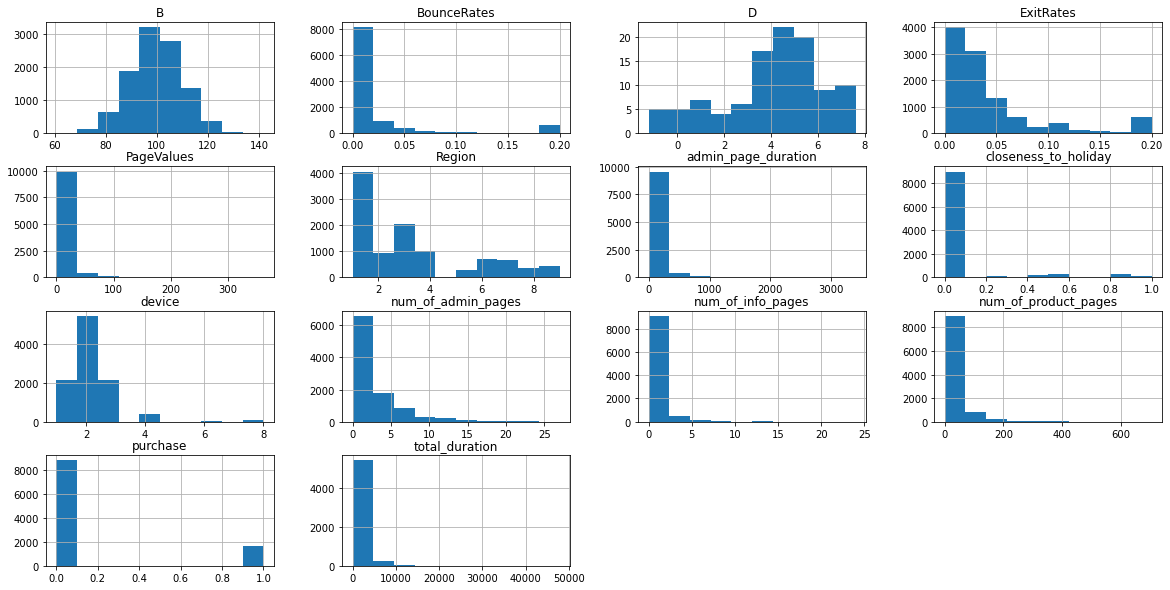

In [6]:
#compute histograms to find distribution of numeric features 
train_data.iloc[:,1:24].hist(figsize=(20,10))

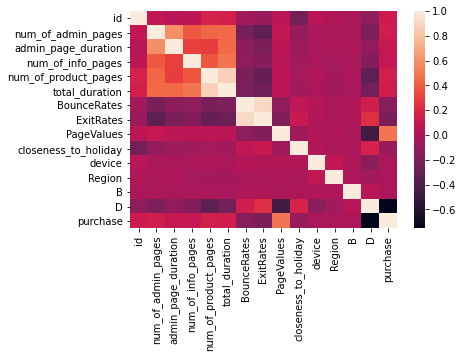

In [7]:
#find correlations by using seaborn heatmap
sns.heatmap(train_data.corr())

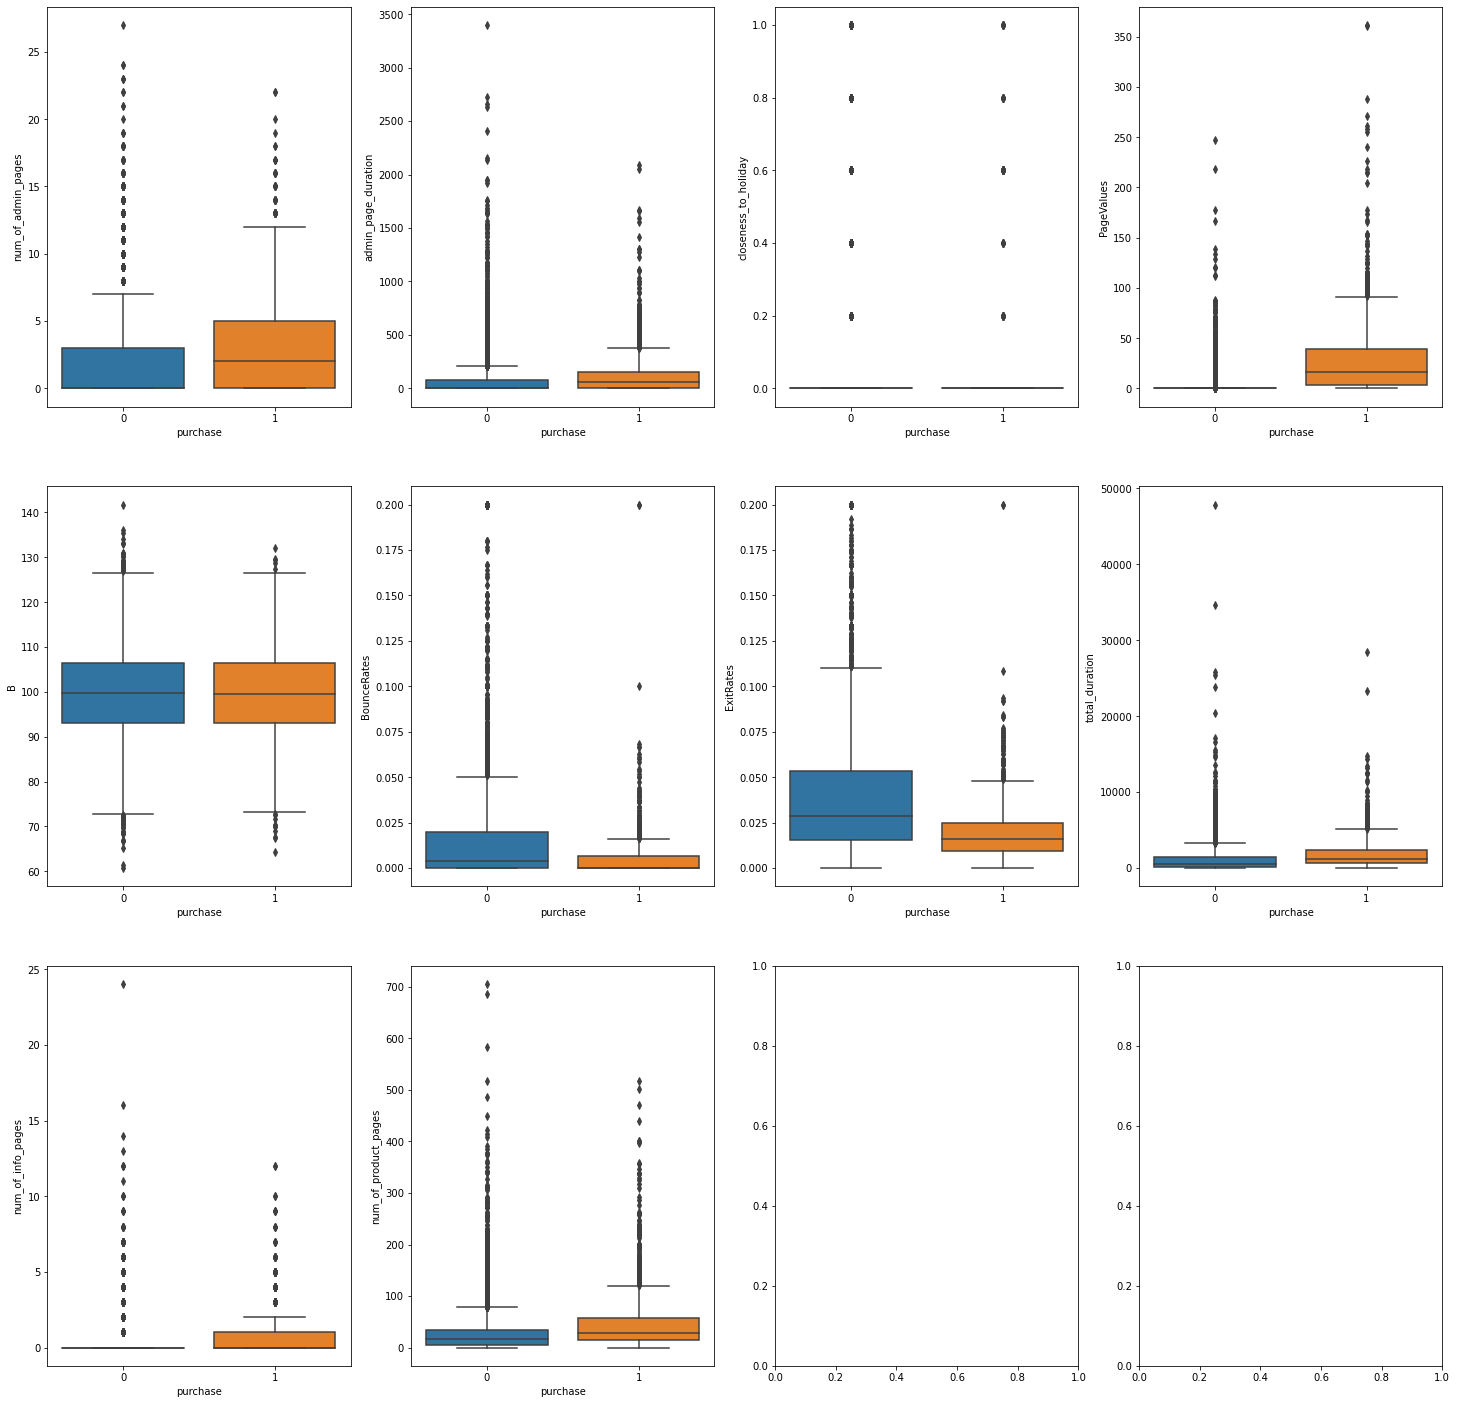

In [8]:
#checking for outliers
features_outliers=train_data[['num_of_admin_pages', 'admin_page_duration', 'closeness_to_holiday', 'PageValues', 
                      'B', 'BounceRates', 'ExitRates',
                  'total_duration', 'num_of_info_pages','num_of_product_pages']]
fig, ax = plt.subplots(3,4,figsize=(25,25))
for i, j in zip(features_outliers,ax.flatten()):
    sns.boxplot(x='purchase', y=i,ax=j, data=train_data)

<p>
by looking at the data, we notice the following: 

1. <u>many features are not numeric</u>. We should consider if some of them will become numeric (for example: info_page_duration)
   or some should become dummy variables.
2. <u> column D seems to have mainly missing values</u> but a very high negative correlation with purchase (-0.75). We should explore that (find if relevant to our model)
    
3. <u>Column C is unkown but might be HTTP response status codes</u>. We should explore the correlation between C and other features,      to make sure our observation is correct. 

4. it seems as though the forumula for total_duration is <u>total_duration = info_page_duration + admin_page_duration + product_page_duration</u>. We should explore how many NaNs we have in this column and think about filling them in. 

5. <u>Scaling is important</u>. The current data isn't not normalized. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. Different featuers have a different scale, and we don't want certain featuers to weight down the model and lead to false results.    
6. Checking for outliers is important. <u>An outlier may indicate bad data</u>. For example, the data may have been coded incorrectly or an experiment may not have been run correctly. We should definetly look into it.
7. We notice, people usually <u>don't purchase items per session</u>. 
8. <u>most popular device is number 2</u>. we should consider regrouping devices 5, 6, 7 and 8. 
9. There seems to be a <u>very high correlation between different pages and different durations (>0.8) </u>. It's good to check, if some should be dropped or rather be merged into one column.
</p>

In [9]:
#finding all non numeric columns
all_cols = train_data.columns
numeric = train_data.select_dtypes(include=[np.number]).columns
cat_cols = list(set(all_cols) - set(numeric))
cat_cols

['info_page_duration',
 'Month',
 'internet_browser',
 'product_page_duration',
 'user_type',
 'C',
 'A',
 'Weekend']

In [10]:
#make a copy of data 
df = train_data.copy()

### Weekend
change the following featuers to numeric only:

In [11]:
def numeric_weekend(col_name, df):
    df[col_name] = df[col_name].replace({True:1,False:0})
    return df
df = numeric_weekend("Weekend", df)

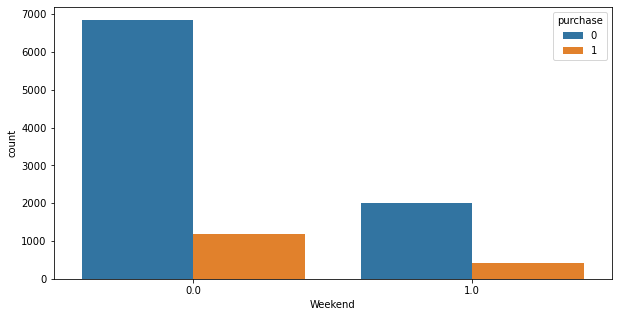

In [12]:
#finding how weekend acts regarding purchase
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Weekend",hue= 'purchase', data = df)
plt.show()

Replacing NaNs with most common value, as shown via plot above - 0 

In [13]:
def replace_nans(col_name, value, df):
    df[col_name] = df[col_name].replace(np.nan, value)
    return df
df = replace_nans("Weekend", 0, df)

### Month

In [14]:
# g = sns.catplot(x="Weekend", hue="Month", col="purchase",
#                 data=df, kind="count",
#                 height=4, aspect=.7);

In [15]:
#change Month column to numeric
df["Month"].value_counts()

May     2857
Nov     2539
Mar     1615
Dec     1450
Oct      471
Sep      379
Jul      367
Aug      365
June     248
Feb      163
Name: Month, dtype: int64

In [16]:
#function changes months to numeric
def make_month_numeric(col_name, df):

    df[col_name] = df[col_name].replace({'Jan' : 1,
                      'Feb' : 2, 
                      'Mar' : 3,
                      'Apr' : 4,
                      'May' : 5,
                      'June' : 6,
                      'Jul' : 7,
                      'Aug' : 8,
                      'Sep' : 9,
                      'Oct' : 10,
                      'Nov' : 11,
                      'Dec' : 12})
    return df
df = make_month_numeric("Month", df)
    
    
df["Month"].value_counts()

5.0     2857
11.0    2539
3.0     1615
12.0    1450
10.0     471
9.0      379
7.0      367
8.0      365
6.0      248
2.0      163
Name: Month, dtype: int64

following plot describes how many purchase occurred during each month:


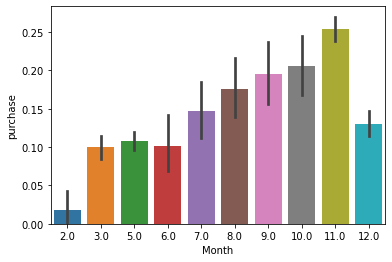

In [17]:
ax = sns.barplot(x="Month", y="purchase", data=df)

<p>
We observe the following: <br>
    1. In this following method, we <u>have months that are more important</u> (example: December comparing to April). <br>
    2. There are <u>more purchases as we move towards the holiday season</u> and less purchases after it (except December as more shopping occurs on events including Black Friday or other major sales events in October or November). <br>
    3. there are <u>missing months</u> - January and April. We should find a way to correct it.<br>
    4. <u>Conclusion</u>: As we are dealing with a project in the field of e-commerce, we consider to make dummies variables that represent quarterly sales. We shall consider engineering a median "January" and "April" according to amount of median monthly purchases in the same quarter. 

Sales quarters are:
<ul>
    <li>January, February, and March (Q1)</li>

<li>April, May, and June (Q2)</li>
<li>July, August, and September (Q3)</li>
<li>October, November, and December (Q4)</li>
        </ul>
</p>

In [18]:
#finding median for January and April
def find_avg_sales(df, quarter):
    lst = []
    for q in quarter:
        col = df[df["Month"] == q]
        cnt = col["Month"].count()
        lst.append(cnt)
    return sum(lst)//len(lst)


#find January 
avg_jan = find_avg_sales(df, [2,3])

#find april
avg_april = find_avg_sales(df, [5,6])

In [19]:
#create dummies - turning months values into categorical variables
def make_dummies(col_name, df):
    
    df = pd.get_dummies(df, columns=[col_name])
    return df

df = make_dummies('Month', df)

In [20]:
df

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase,Month_2.0,Month_3.0,Month_5.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.000000,0.0,1.0,safari_15,1.0,Returning_Visitor,0.0,c_1,118.880094,log202,NaN,0,1,0,0,0,0,0,0,0,0,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,0.000000,0.0,4.0,safari_14,9.0,Returning_Visitor,0.0,c_3,113.358423,log404,NaN,0,1,0,0,0,0,0,0,0,0,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,0.000000,0.0,3.0,browser_3_v17,1.0,Returning_Visitor,1.0,c_4,121.507695,log202,NaN,0,1,0,0,0,0,0,0,0,0,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,0.000000,0.0,2.0,chrome_99.1.3,1.0,Returning_Visitor,0.0,c_3,93.747176,log_100,NaN,0,1,0,0,0,0,0,0,0,0,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.000000,0.4,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,0.0,c_3,99.545824,log202,NaN,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,10474,3.0,145.0,0.0,0.0 minutes,53.0,1783.791667 minutes,1928.791667,0.007143,0.029031,12.241717,0.0,4.0,browser_6_v12,1.0,Returning_Visitor,1.0,c_1,79.548460,log400,NaN,0,0,0,0,0,0,0,0,0,0,1
10475,10475,0.0,0.0,0.0,0.0 minutes,5.0,465.75 minutes,NaN,0.000000,0.021333,0.000000,0.0,3.0,chrome_98.0.1,1.0,Returning_Visitor,1.0,c_8,99.457255,log202,NaN,0,0,0,0,0,0,0,0,0,1,0
10476,10476,0.0,0.0,0.0,0.0 minutes,6.0,184.25 minutes,NaN,0.083333,0.086667,0.000000,0.0,3.0,chrome_99.1.3,1.0,Returning_Visitor,1.0,c_13,94.417344,log8080,NaN,0,0,0,0,0,0,0,0,0,1,0
10477,10477,4.0,75.0,0.0,0.0 minutes,15.0,346.0 minutes,NaN,0.000000,0.021053,0.000000,0.0,2.0,chrome_80,3.0,Returning_Visitor,0.0,c_11,108.919057,log400,NaN,0,0,0,0,0,0,0,0,0,1,0


In [21]:
#grouping months into quarters
def group_dummies_months(lst, df):
    
    q1 = [lst[0], lst[1]]
    q2 = [lst[2], lst[3]]
    q3 = [lst[4], lst[5], lst[6]]
    q4 = [lst[7], lst[8], lst[9]]

    df['q_1'] = df[q1].sum(axis=1)
    df['q_2'] = df[q2].sum(axis=1)
    df['q_3'] = df[q3].sum(axis=1)
    df['q_4'] = df[q4].sum(axis=1)
    
    return df

months_list = ["Month_2.0", "Month_3.0", "Month_5.0", "Month_6.0",
"Month_7.0", "Month_8.0", "Month_9.0",
"Month_10.0", "Month_11.0", "Month_12.0"]

df = group_dummies_months(months_list, df)



# df = df.drop(columns = ["Month_2.0", "Month_3.0","Month_5.0", "Month_6.0","Month_7.0", 
#                         "Month_8.0", "Month_9.0","Month_10.0", "Month_11.0", "Month_12.0"] ,inplace=False)


In [22]:
#droping duplicates
def drop_cols(cols_list, df):
    for col in cols_list:
        df = df.drop(columns = [col])
    return df
drop_list = ["Month_2.0", "Month_3.0","Month_5.0", "Month_6.0","Month_7.0", 
                        "Month_8.0", "Month_9.0","Month_10.0", "Month_11.0", "Month_12.0"]
df = drop_cols(drop_list, df)



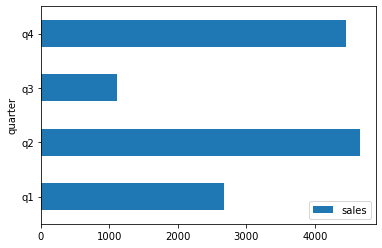

In [23]:
#compare between quarters by using additional average found before
count_q_1 = (df['q_1']).sum() + avg_jan
count_q_2 = (df['q_2']).sum() + avg_april
count_q_3 = (df['q_3']).sum()
count_q_4 = (df['q_4']).sum()

plot1 = pd.DataFrame({'quarter':['q1', 'q2', 'q3', 'q4'], 'sales':[count_q_1, count_q_2, count_q_3, count_q_4]})
ax = plot1.plot.barh(x='quarter', y='sales')

it seems as though, there are many sales during q4 (holiday season) and even more during q2 comparing to q1 and q3 (even after adding average of missing months). q2 sales might be Ester and certain bank holidays (depending on Region).

### D
we explore column D for missing values after looking at the plot in the beginning of the notebook.

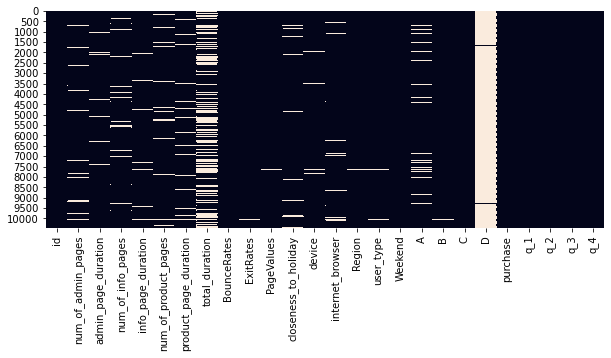

In [24]:
#show missing values in plot
plt.figure(figsize = (10,4))
sns.heatmap(df.isnull(), cbar=False) 
plt.show()

In [25]:
df.isnull().sum().sort_values(ascending=False)[:25]

D                        10374
total_duration            4753
A                          706
num_of_info_pages          687
product_page_duration      621
num_of_admin_pages         605
internet_browser           563
closeness_to_holiday       496
admin_page_duration        413
num_of_product_pages       403
device                     323
info_page_duration         317
PageValues                  27
ExitRates                   26
user_type                   23
B                           23
C                           23
BounceRates                 22
Region                      19
q_4                          0
q_3                          0
Weekend                      0
purchase                     0
q_1                          0
q_2                          0
dtype: int64

<p>There seems to be many missing values in column D (10374 out of 10479). We decide to drop it, as it contributes little value to our model. In case we would like to fill it with 0, 1, median or any other value, this will become our main value and effects the correlation greatly. </p>

In [26]:
#drop D
df = drop_cols(["D"], df)
# df = df.drop(columns = ["D"] ,inplace=False)

### Product/Info/Admin/Total Page duration

we should change product_page_duration and info_page_duration to numeric. <br> The motivation: we want to fill out all total_duration NaNs. 


In [27]:
#changing product_page_duration and info_prage_duation
def change_duration_numeric(col_name, df):
    df[col_name] = df[col_name].str.replace("minutes","")
    df[col_name]= df[col_name].astype(float)
    return df
df = change_duration_numeric("product_page_duration", df)
df = change_duration_numeric("info_page_duration", df) 
    
# df["product_page_duration"]= df["product_page_duration"].str.replace("minutes","")
# df["product_page_duration"]= df["product_page_duration"].astype(float)


In [28]:
df["info_page_duration"].median()

0.0

In [29]:
df["product_page_duration"].median()

598.44166665

In [30]:
df["admin_page_duration"].median()

8.0

<p><u>Filling out NaNs for different pages durations:</u>
    <br>
    when looking at the <u>info_page_duration data, we should consider turning all NaNs to 0</u>. <br>
The decision to change all to 0, was by inspecting the raw data. <br>
We should make sure, our decision (based on the equation 
info_page_duration + admin_page_duration + product_page_duration = total_duration)<br>
is correct.
<br>
We do have second thoughts: <br>1. the median (which is not sensitive to outliers) info_page_duration is 0. Therefore, what we did makes sense. Let's continue.
</p>

In [31]:
# def replace_nans(col_name, value, df):
#     df[col_name] = df[col_name].replace(np.nan, value)
#     return df
df = replace_nans("info_page_duration", 0, df)

# df['info_page_duration'] = df['info_page_duration'].replace(np.nan, 0)
df['info_page_duration'].isnull().values.any()

False

<p>
    2. the median the <u>num_of_admin_pages</u> is 8. Therefore, what we did (filling out NaNs with 0's) makes sense in a whole.
    </p>

In [32]:
df = replace_nans("admin_page_duration", 0, df)

# df['admin_page_duration'] = df['admin_page_duration'].replace(np.nan, 0)
df['admin_page_duration'].isnull().values.any()

False

<p>
    3. 75% of the <u>num_of_product_pages</u> 38.000000. This makes little sense to replace NaNs with 0. <br>
   Therefore, we should look into it. <br>
    </p>

In [33]:
df

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,internet_browser,Region,user_type,Weekend,A,B,C,purchase,q_1,q_2,q_3,q_4
0,0,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,0.000000,0.0,1.0,safari_15,1.0,Returning_Visitor,0.0,c_1,118.880094,log202,0,1,0,0,0
1,1,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.200000,0.200000,0.000000,0.0,4.0,safari_14,9.0,Returning_Visitor,0.0,c_3,113.358423,log404,0,1,0,0,0
2,2,0.0,0.0,0.0,0.0,NaN,627.500000,627.500000,0.020000,0.050000,0.000000,0.0,3.0,browser_3_v17,1.0,Returning_Visitor,1.0,c_4,121.507695,log202,0,1,0,0,0
3,3,0.0,0.0,0.0,0.0,19.0,154.216667,154.216667,0.015789,0.024561,0.000000,0.0,2.0,chrome_99.1.3,1.0,Returning_Visitor,0.0,c_3,93.747176,log_100,0,1,0,0,0
4,4,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,0.000000,0.4,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,0.0,c_3,99.545824,log202,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,10474,3.0,145.0,0.0,0.0,53.0,1783.791667,1928.791667,0.007143,0.029031,12.241717,0.0,4.0,browser_6_v12,1.0,Returning_Visitor,1.0,c_1,79.548460,log400,0,0,0,0,1
10475,10475,0.0,0.0,0.0,0.0,5.0,465.750000,NaN,0.000000,0.021333,0.000000,0.0,3.0,chrome_98.0.1,1.0,Returning_Visitor,1.0,c_8,99.457255,log202,0,0,0,0,1
10476,10476,0.0,0.0,0.0,0.0,6.0,184.250000,NaN,0.083333,0.086667,0.000000,0.0,3.0,chrome_99.1.3,1.0,Returning_Visitor,1.0,c_13,94.417344,log8080,0,0,0,0,1
10477,10477,4.0,75.0,0.0,0.0,15.0,346.000000,NaN,0.000000,0.021053,0.000000,0.0,2.0,chrome_80,3.0,Returning_Visitor,0.0,c_11,108.919057,log400,0,0,0,0,1


<u>The following steps algoritham will replace NaN values in 'product_page_duration' and in 'total_duration':</u> <br>
1. Fill NaNs in 'product_page_duration' column according to the above 'total_duration' formula. 
2. In case NaNs are left in 'product_page_duration' column, we replace them with the median spent on a product page times the number of pages. 
3. In the case of remaining NaNs (the seesion's product page count is NaN), we replace with 0. 
4. To overcome NaNs issue in 'total_duration' column, a new column is created 'total_duration_full'. We replace NaNs according to the total duration formula presented above. 

The goal is having all duration columns without any NaNs. 

In [34]:
def fill_product_by_formula(row, df):
    dur1 = row['product_page_duration']
    dur2 = row['info_page_duration']
    dur3 = row['admin_page_duration']
    dur4 = row['total_duration']
    
    if np.isnan(dur1): 
        return dur4 - dur2 - dur3
    else:
        return dur1
df['product_page_duration'] = df.apply(lambda row : fill_product_by_formula(row, df), axis=1)

In [35]:
df["product_page_duration"].isna().sum()

276

In [36]:
#find estimated time spent on a product page times the number of pages

def fill_with_product_page(row, df):
    
    page = row["num_of_product_pages"]
    page_median = df["num_of_product_pages"].median() 
    val_median = df["product_page_duration"].median()
    dur = row["product_page_duration"]
    
    if np.isnan(dur) and pd.notna(page):
        return page*(val_median/page_median)
    else:
        return dur
    
df['product_page_duration'] = df.apply(lambda row : fill_with_product_page(row, df), axis=1)

df['product_page_duration'].isna().sum()

16

In [37]:
df['product_page_duration'] = df['product_page_duration'].replace(np.nan, 0)
df['product_page_duration'].isnull().values.any()

False

In [38]:
def fill_total_by_formula(row, df):
    dur1 = row['product_page_duration']
    dur2 = row['info_page_duration']
    dur3 = row['admin_page_duration']
    dur4 = row['total_duration']
    
    if np.isnan(dur4): 
        return dur1 + dur2 + dur3
    else:
        return dur4
df['total_duration_full'] = df.apply(lambda row : fill_total_by_formula(row, df), axis=1)

In [39]:
df['total_duration_full'].isna().sum()

0

In [40]:
df = drop_cols(["total_duration"], df)


After the duration columns pre-processing,  we should think about the way this data is distributed. <br>
Motivation: We need to check for extreme points, using Boxplot or similiar methods to see how the data is "acting" at the outliers (In case of extreme observations, we should consider "cleaning" the data). This will help us understand if we should consider normalizing this columns. 


In [41]:
df["total_duration_full"].describe()

count    10479.000000
mean      1301.751048
std       2059.501893
min          0.000000
25%        218.350000
50%        675.500000
75%       1619.285437
max      69921.647230
Name: total_duration_full, dtype: float64

It can be observed that "total_duration_full" have very deferred maximum value as compared to the 75% value, thus we can say there are certain observations that act as outliers in the dataset. 

It can be verified by plotting a box plot of the above feature.

In [42]:
df

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,internet_browser,Region,user_type,Weekend,A,B,C,purchase,q_1,q_2,q_3,q_4,total_duration_full
0,0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,1.0,safari_15,1.0,Returning_Visitor,0.0,c_1,118.880094,log202,0,1,0,0,0,0.000000
1,1,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,4.0,safari_14,9.0,Returning_Visitor,0.0,c_3,113.358423,log404,0,1,0,0,0,0.000000
2,2,0.0,0.0,0.0,0.0,NaN,627.500000,0.020000,0.050000,0.000000,0.0,3.0,browser_3_v17,1.0,Returning_Visitor,1.0,c_4,121.507695,log202,0,1,0,0,0,627.500000
3,3,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.000000,0.0,2.0,chrome_99.1.3,1.0,Returning_Visitor,0.0,c_3,93.747176,log_100,0,1,0,0,0,154.216667
4,4,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.4,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,0.0,c_3,99.545824,log202,0,1,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,10474,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,4.0,browser_6_v12,1.0,Returning_Visitor,1.0,c_1,79.548460,log400,0,0,0,0,1,1928.791667
10475,10475,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,3.0,chrome_98.0.1,1.0,Returning_Visitor,1.0,c_8,99.457255,log202,0,0,0,0,1,465.750000
10476,10476,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,3.0,chrome_99.1.3,1.0,Returning_Visitor,1.0,c_13,94.417344,log8080,0,0,0,0,1,184.250000
10477,10477,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,2.0,chrome_80,3.0,Returning_Visitor,0.0,c_11,108.919057,log400,0,0,0,0,1,421.000000


<p>Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).
This type of plot is used to easily detect outliers. It can also tell us if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.</p>
<u>Note</u>: we know data isn't normal, but still used Boxplot to clean outliers (as we understood normal distribution is not mandatory for this plot).

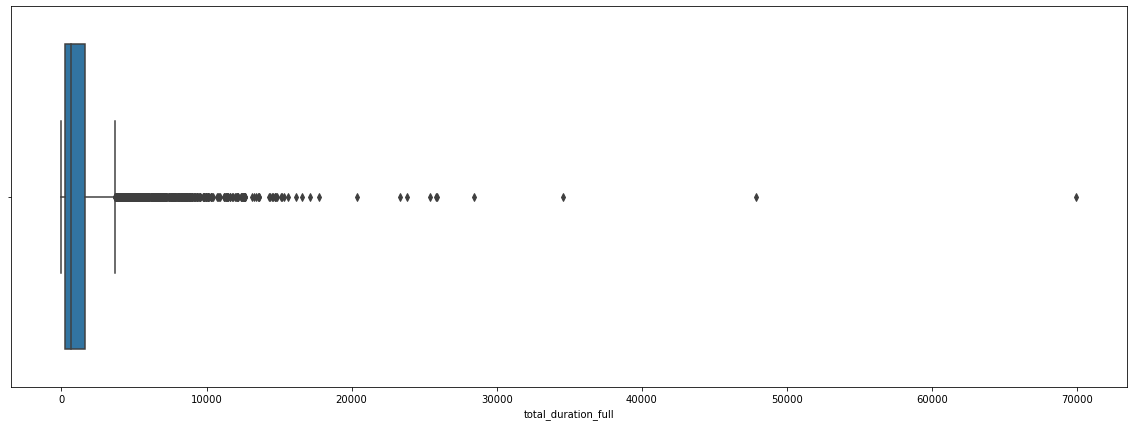

In [43]:
plt.figure(figsize=(20,7))
sns.boxplot(df["total_duration_full"])
plt.show()

<p>
We will <u>continue processing the total_duration_full column</u> in the following steps: <br>
    1. <u>Outliers removal:</u> total_duration_full column isn't normally distrubted. We will <u>remove all values that are larger than 75% of the data</u> (in our case, bigger than 1619.285437). <br>
2. Normalize column. Motivation: we don't want certain featuers to get more importance and weight down our model <u>with no legitimate reason</u>.
    </p>

In [44]:
# top_75_percentage = 1619.285437
top_75_percentage = np.percentile(df["total_duration_full"], 75)

df = df.drop(df[df["total_duration_full"] > top_75_percentage].index)

1900.7351189999997


count    7859.000000
mean      526.170160
std       447.127138
min         0.000000
25%       137.937500
50%       418.333333
75%       843.056548
max      1618.708571
Name: total_duration_full, dtype: float64

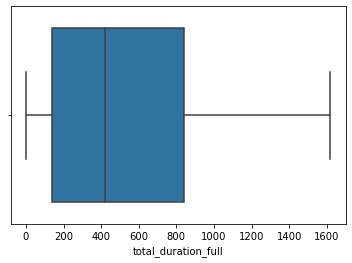

In [45]:
# Computing IQR
Q1 = df["total_duration_full"].quantile(0.25)

Q3 = df["total_duration_full"].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
filtered = df.query('(@Q1 - 1.5 * @IQR) <= total_duration_full <= (@Q3 + 1.5 * @IQR)')
print(Q3 + 1.5 * IQR)
sns.boxplot(filtered["total_duration_full"])
filtered["total_duration_full"].describe()

Boxplot looks much better. Success!

<!-- By looking at the "total_duration_full" column (after removing the outliers) we decide to normalize this column.
As seen in lecture:
0-1: make all features between 0 and 1 by reducing the minimal value and 
dividing by the max)

Motivation:
By looking at ExitRate, BounceRate columns (range 0 to 0.2) and other numeric columns (0 to 1), we don't want the "total_duration_full" or any other columns observations to outscale, therefore we will normalize them. 
 -->

### Num_of_admin/info/product Page
We woluld like to engineer a new feature. Therefore, we need to fill out all missing NaNs values of these different pages. 

<p style="color:Tomato;">Feature engineering:</p>
<p>
    1. <u>combine number of all different pages into total_pages column column</u>, as we want to reduce dimension and still have the same information. 
Afterwards, will drop all the pages column, as they're a part of the total_num_page. Otherwise, there would be a very strong correlation that will result in overfitting which we would try to avoid.<br>
2. As we want to reduce number of dimensions, we <u>decide to engineer a new feature which represents the average page duration</u>.
The formula is: avg_dur_per_page = total_duration_full/total_num_page.<br> <u>Motivation</u>: users might spend a lot of time on different pages, with no apparent reason (for instance, staying logged-in although not next to device). We would like to eliminate that issue by finding average time per page during session. <br>
    3. Eventually, we <u>standardize avg_dur_per_page</u> to fit with the scale of other features in our data.    
</p>

In [46]:
#check how many nans in num_of_admin_pages, num_of_info_pages, num_of_product_pages 
df.isnull().sum()

id                         0
num_of_admin_pages       459
admin_page_duration        0
num_of_info_pages        517
info_page_duration         0
num_of_product_pages     319
product_page_duration      0
BounceRates               18
ExitRates                 16
PageValues                19
closeness_to_holiday     382
device                   250
internet_browser         421
Region                    16
user_type                 19
Weekend                    0
A                        531
B                         19
C                         18
purchase                   0
q_1                        0
q_2                        0
q_3                        0
q_4                        0
total_duration_full        0
dtype: int64

In [47]:
df["num_of_admin_pages"].describe()
#mostly 0 values

count    7400.000000
mean        1.580405
std         2.490424
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        18.000000
Name: num_of_admin_pages, dtype: float64

In [48]:
df["num_of_info_pages"].describe() 
#values mostly 0

count    7342.000000
mean        0.255925
std         0.817173
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        16.000000
Name: num_of_info_pages, dtype: float64

In [49]:
df["num_of_product_pages"].describe()

count    7540.000000
mean       16.160477
std        14.422122
min         0.000000
25%         5.000000
50%        12.000000
75%        23.000000
max       114.000000
Name: num_of_product_pages, dtype: float64

After looking at pages data, we decide to fill all columns except num_of_product_pages with 0. <br>
num_of_product_pages missing values' will be the mean.  

In [50]:
df = replace_nans("num_of_admin_pages", 0, df)
df = replace_nans("num_of_info_pages", 0, df)
df = replace_nans("num_of_product_pages", df["num_of_product_pages"].median(), df)

combaine "num_of_admin_pages", "num_of_info_pages", "num_of_product_pages" into one column called total_num_page which represents the total number of all pages during the session. <br>
<u>Motivation</u>: We observed the behavior of users regarding different pages, and noticed, that users usually visit product page resulting (which results in a higher product page duration). Combining all columns into one seems reasonable, as product pages are more significant, yet dropping other columns seems unnecessary and might even lead to worse model performance.  

In [51]:
def comb_cols(lst, new_col, df):
    df[new_col] = df[lst].sum(axis=1)
    return df
page_lst = ["num_of_admin_pages", "num_of_info_pages", "num_of_product_pages"]
df = comb_cols(page_lst, "total_num_page", df)

In [52]:
df["total_num_page"].value_counts()

1.0      474
12.0     444
2.0      344
3.0      298
6.0      297
        ... 
98.0       1
94.0       1
115.0      1
93.0       1
86.0       1
Name: total_num_page, Length: 102, dtype: int64

In [53]:
#drop duplicates
df = drop_cols(["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration", 
         "num_of_product_pages", "product_page_duration"], df)
# df = df.drop(columns = ["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration", 
#          "num_of_product_pages", "product_page_duration"])

<p style="color:Tomato;">Feature engineering:</p>
create avg_per_page column, which represent average time user spent on each page during session.

In [54]:
#make new feature - total_num_page
def find_avg_per_page(new_col, total_dur_col, total_num_col, df):
    df[new_col] = df[total_dur_col]/df[total_num_col]
    return df
df = find_avg_per_page("avg_dur_per_page", "total_duration_full", "total_num_page", df)    

# df["avg_dur_per_page"] = df["total_duration_full"]/df["total_num_page"]

In [55]:
#in case of dividing in 0
df = replace_nans("avg_dur_per_page", 0, df)

#in case of infs 
def replace_inf(col_name, value, df):
    df[col_name] = df[col_name].replace([np.inf, -np.inf], value)
    return df

df = replace_inf("avg_dur_per_page", 0, df)    
df["avg_dur_per_page"] = df["avg_dur_per_page"].replace([np.NaN ,np.inf, -np.inf], 0, inplace=False)


In [56]:
df = drop_cols(["total_duration_full", "total_num_page"], df)

In [57]:
#normalize "avg_dur_per_page"
#could have used the following min/max normalization as seen in class, yet wrote a function, same as:
#avg_dur=(df["avg_dur_per_page"]-df["avg_dur_per_page"].min())/(df["avg_dur_per_page"].max()-df["avg_dur_per_page"].min())
def make_between_zero_to_one(col_name, df):
    df[col_name] = df[col_name]/df[col_name].max()
    return df

df = make_between_zero_to_one("avg_dur_per_page", df)

In [58]:
df["avg_dur_per_page"].describe()

count    7859.000000
mean        0.023215
std         0.027700
min         0.000000
25%         0.011256
50%         0.018429
75%         0.027970
max         1.000000
Name: avg_dur_per_page, dtype: float64

### Exit/Bounce Rates
<p>
BounceRates: Google Analytics measure for percentage of users who enter the site from a specific page and then leave. <br>
ExitRates: Google Analytics measure for percentage of users who left the site from a specific page.<br>
    By reading this description, both features seem to have a <u>pretty similiar function</u>. This might lead to a high correlation. Let's check into it.  </p>

(14.5, -0.5)

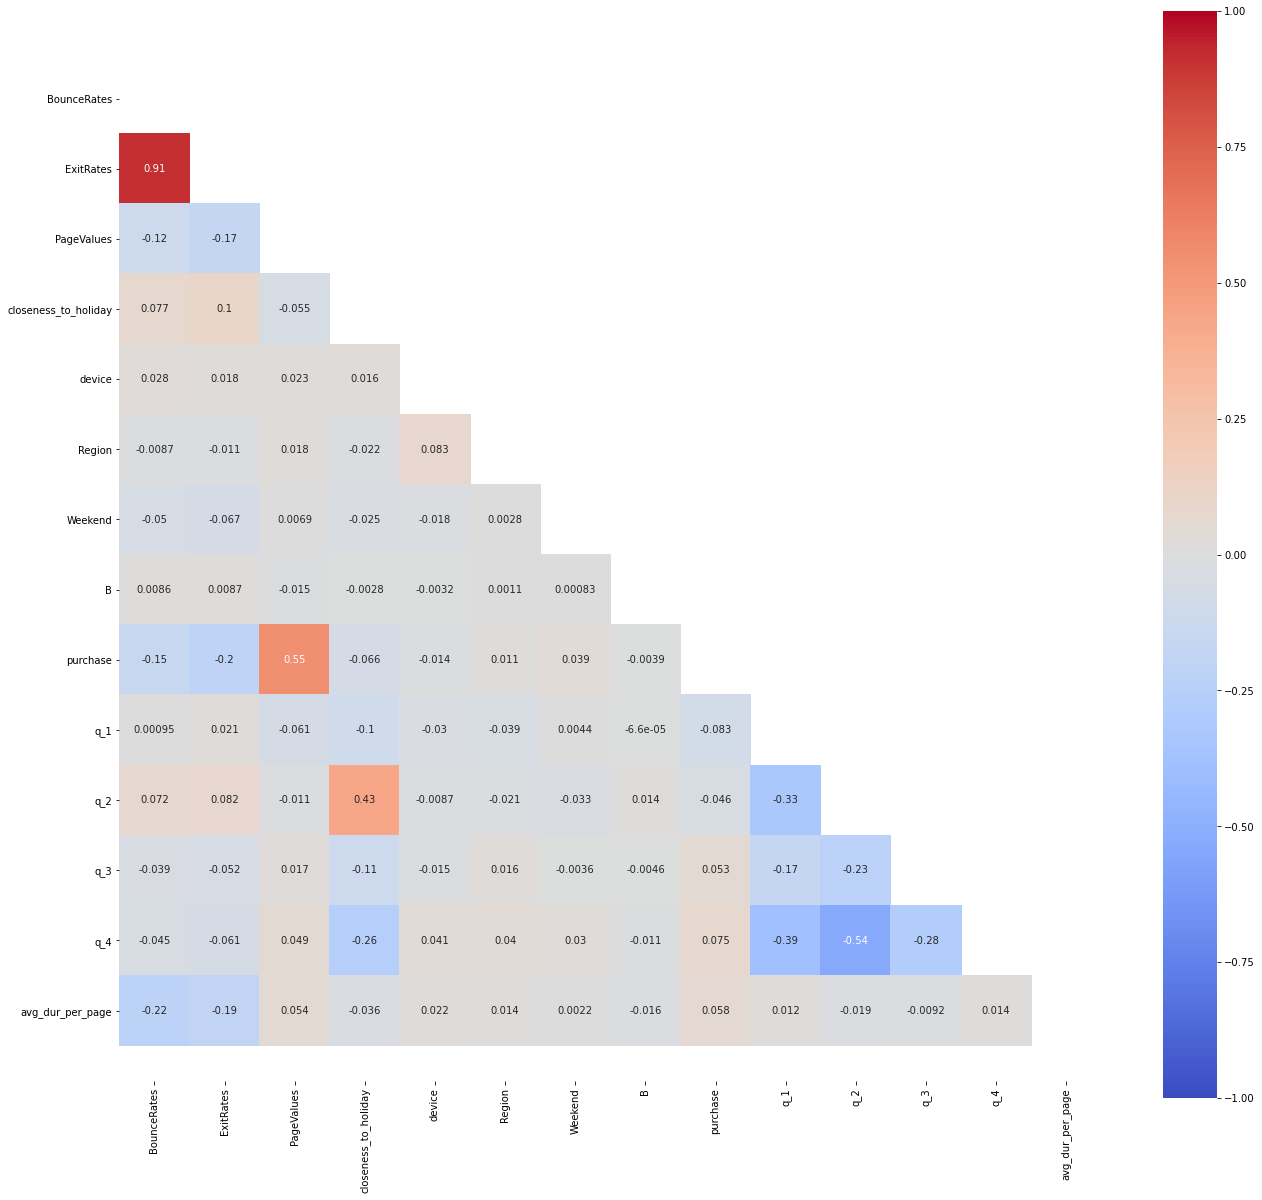

In [59]:
#correlation matrix 
plt.figure(figsize = (22,20))
data_for_cor = df.loc[:, df.columns != 'id']
# triu is a NumPy method returning lower triangle of a given matrix.
tri_matrix = np.triu(data_for_cor.corr())

# Plot heatmap
sns.heatmap(data_for_cor.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square = True, mask = tri_matrix)
# Fix the issue with the upper and lower borders get cut_off
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

as expected, there is a <u>high correlation between ExitRates and BounceRate (0.91%)</u>. <br> 
According to the heatmap, it's better to keep BounceRate (-0.15% comparing to ExitRates' -0.20%). 
We decide to keep one of them and normalize it.

In [60]:
df = drop_cols(["ExitRates"], df)
# df = df.drop(columns = ["ExitRates"] ,inplace=False)

Possible direction we decided to leave out (as it didn't change the prediction of our model):
In the beginning of the Notebook, we explored different boxplots including BounceRates and saw a strange behavior at the whiskers. Using a boxplot we decided to clean the data, and normalize it. We left the attempt in comment. 

In [61]:
df["BounceRates"].describe()

count    7841.000000
mean        0.026684
std         0.054390
min         0.000000
25%         0.000000
50%         0.000000
75%         0.022222
max         0.200000
Name: BounceRates, dtype: float64

BounceRates column seems to be ranging 0 to 0.2 comparing to other columns designed to be 0 to 1.
Max is 0.2 yet, 75% of the observations are less than 0.022222. 

histogram shows the density of the data.

(array([5724.,  766.,  341.,  189.,   64.,  103.,   35.,   22.,    9.,
         588.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <a list of 10 Patch objects>)

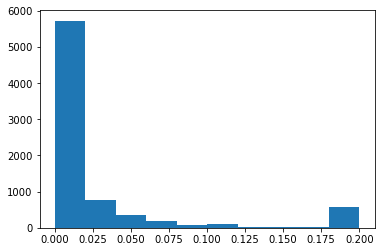

In [62]:
plt.hist(df['BounceRates'])

In [63]:
# plt.figure(figsize=(20,7))
# sns.boxplot(df["BounceRates"])
# plt.show()

In [64]:
# bounceRates_75_per = np.percentile(df["BounceRates"], 75)

# df = df.drop(df[df["BounceRates"] > bounceRates_75_per].index)

In [65]:
# df["BounceRates"] = df["BounceRates"]-df["BounceRates"].min()/(df["BounceRates"].max()-df["BounceRates"].min())

In [66]:
#as values between 0 and 0.2 and other features between 0 and 1
def make_between_zero_to_one_multi(col_name, num, df):
    df[col_name] = df[col_name]*num
    return df
df = make_between_zero_to_one_multi("BounceRates", 5, df)

In [67]:
df["BounceRates"].describe()

count    7841.000000
mean        0.133419
std         0.271951
min         0.000000
25%         0.000000
50%         0.000000
75%         0.111111
max         1.000000
Name: BounceRates, dtype: float64

In [68]:
# # Computing IQR
# Q1 = df["BounceRates"].quantile(0.25)

# Q3 = df["BounceRates"].quantile(0.75)
# IQR = Q3 - Q1

# # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
# filtered = df.query('(@Q1 - 1.5 * @IQR) <= BounceRates <= (@Q3 + 1.5 * @IQR)')
# print(Q3 + 1.5 * IQR)
# sns.boxplot(filtered["BounceRates"])
# filtered["BounceRates"].describe()

most of values are 0, therefore replace NaNs with 0 (as seen by describe).

In [69]:
df = replace_nans("BounceRates", 0, df)

### C
Column C is unkown but might be <u>HTTP response status codes</u>.

In [70]:
#explore column C
df["C"].value_counts()

log8080    1345
log200     1329
log400     1324
log404     1311
log_100    1305
log202     1227
Name: C, dtype: int64

<p>
By searching Google we found the following HTTP respones: <br>
    100 - Information responses<br>
    200, 202 - Successful responses<br>
    400, 404 - Client error responses<br> 
    8080 - port (instead of port 80)<br>
    
<u>we can consider grouping them (Dummy variables) in the following way<u>:

100, 200, 202 - Successful responses<br>
400, 404 - Client error responses<br>
8080 - port

We are not sure about 8080, therefore we make into it's own category and see the correlation between this 
category and the page value.

It might be, that our observation is incorrect. Therefore, we will use the correlation with purchase and page value to see 
if we are right. 
<br>
<br>
We will expect the following:
<br>
<br>
if the page_value is high, it will probably mean there was a purchase or a high possibility for one 
(for instance: cart). <br>
We will expect to have a lower PageValues if page has an error status of 400 or 404.
    
<u>Algoritham: 
    We decided to combine all the error codes to one column again. We decided to change all "good_resp" to 1, "bad_resp" to -1, and "copy_C_log8080" to 0 in order to make categorial columns to one numeric column</u>.  <br>

Motivation: reducing dimension. In our understanding, encountering 400 codes will decrease the probability of purchasing, comparing to 200 codes. 8080 port code has an undefinied behaviour therefore will be tagged as 0 value.
    </p>

In [71]:
def change_to_log_code(new_col, old_col, log_list, df):
    df[new_col] = df[old_col].replace({log_list[0]: 1, log_list[1]: 1, 
                                         log_list[2]: 1, log_list[3]: -1, log_list[4] :-1, log_list[5] :0})
    return df
    
log_list = ["log200", "log202", "log_100", "log400", "log404", "log8080"]
df = change_to_log_code("log_code", "C", log_list, df)


df = drop_cols(["C"], df)


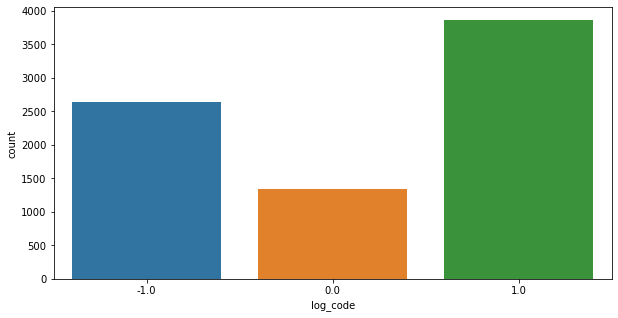

In [72]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x= "log_code", data = df)
plt.show()

In [73]:
#fill NaNs by adding to most common group 1
df = replace_nans("log_code", 1, df)

### User type
There are less New visitors, yet they tend to purchase more comparing to Returning vistiors. The other column doesn't provide us sufficient information. We decide to turn this column into <u>3 dummy variable</u> and see if there might by any correlation. We assume a very high negative corrleation between New Visitors and Returning Visitors as user can't be both.

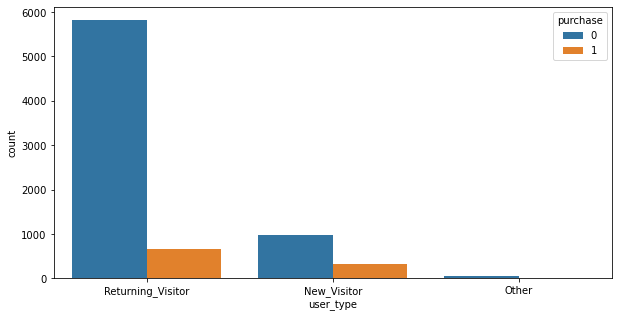

In [74]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="user_type",hue= 'purchase', data = df)
plt.show()

In [75]:
#make a copy of user_type
df["copy_user_type"] = df["user_type"]
df = make_dummies("copy_user_type", df)
# df = pd.get_dummies(df, columns=['copy_user_type'])

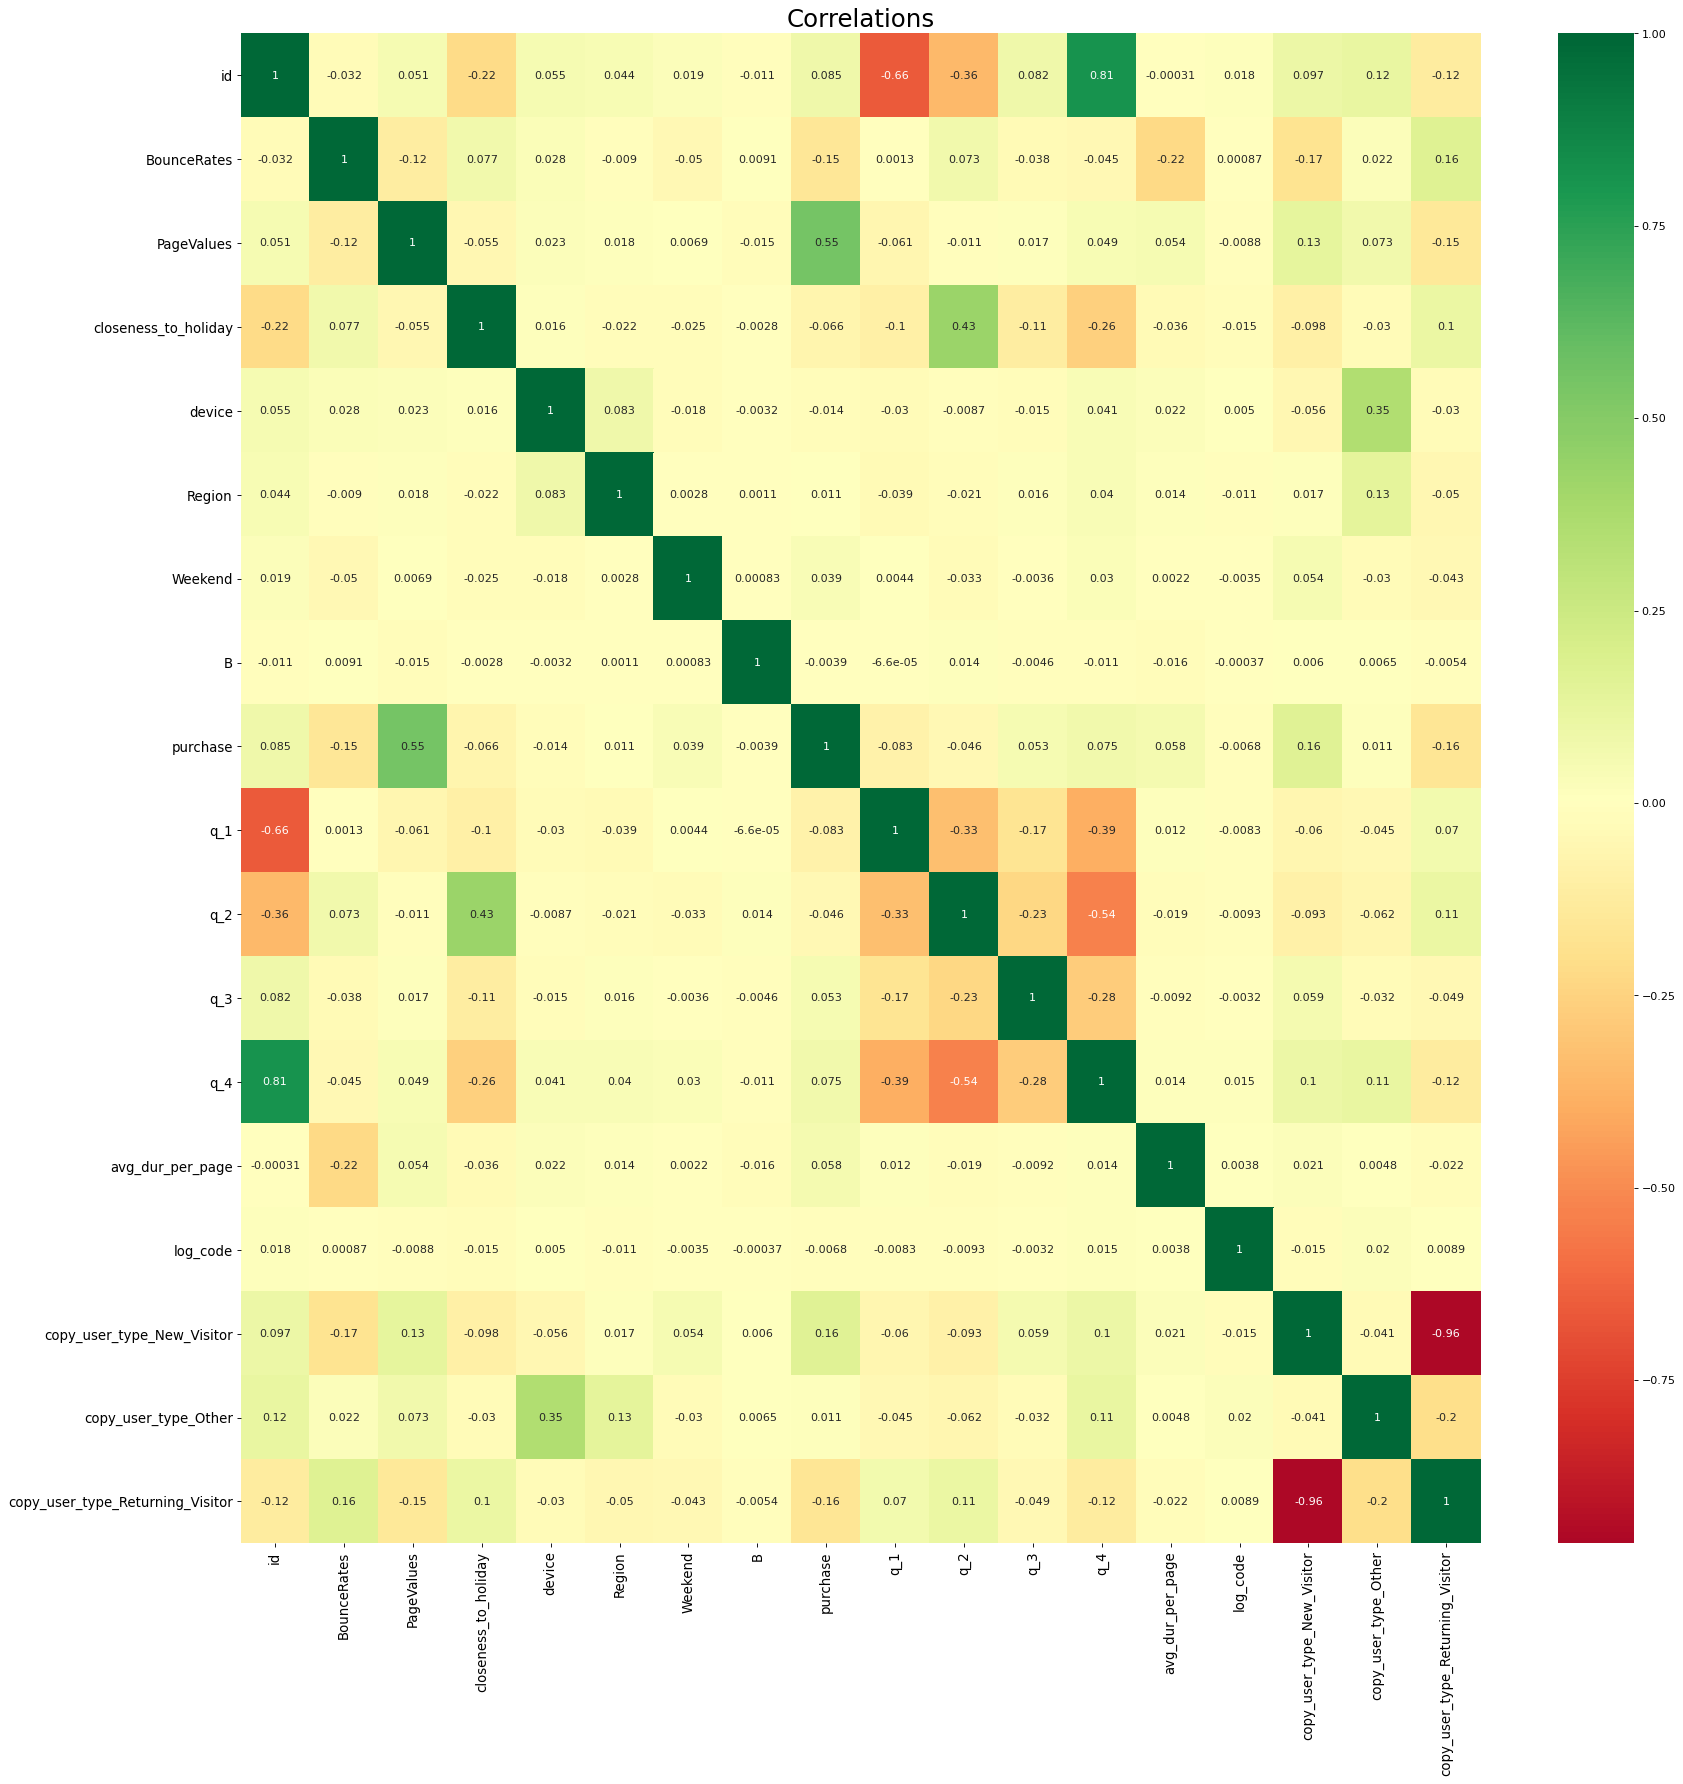

In [76]:
#find correlations between 
plt.figure(figsize=(25,25), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlations', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As expected, there seems to be a strong negative correlation (-0.96) between Returning visitor and new visitor. Therefore, we decide to make <u>Other user type into 0</u> (little information that won't effect our column), <u>Returning -1</u> (as they tend to buy less), and <u>New Visitor 1</u>.  

In [77]:
def replace_user_type(name_col, user_list, df):
    df[name_col] = df[name_col].replace({user_list[0]: -1, user_list[1]: 1, user_list[2]: 0})
    return df
user_list = ["Returning_Visitor", "New_Visitor", "Other"]

df = replace_user_type("user_type", user_list, df)


In [78]:
df = drop_cols(["copy_user_type_New_Visitor", "copy_user_type_Other", 
                       "copy_user_type_Returning_Visitor"], df)

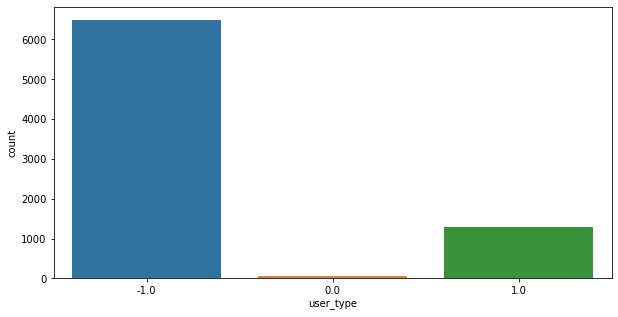

In [79]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x= "user_type", data = df)
plt.show()

Plot shows, that most of the users are Returning visitors (= -1). NaNs will be replaced with most common value which is -1. 

In [80]:
#NaNs with higher probability to be -1
df = replace_nans("user_type" ,-1, df)

### Internet Browser and Device
We assume there might be a connection between these two columns, as there are devices that use certain browsers or <u>certain browsers are more popularly used via certain devices (example: PC device and Edge Browser).</u> <br>
There might be also different user profiles. for instance, users using Mac (Safari browser). 
By checking online, we found out that if you use a Mac or an Android, e-commerce sites may be charging you more (this might, of course, effect users' desicion to make a purchase). This is way, sometimes people use incognito mode. We would like to see if there's some unkown browsers in our data. 
For more information: https://www.washingtonpost.com/posteverything/wp/2014/11/03/if-you-use-a-mac-or-an-android-e-commerce-sites-may-be-charging-you-more/ <br>
We will look into these leads.

In [81]:
df = make_dummies("device", df)

In [82]:
# df["copy_device"] = df["device"]

# df = pd.get_dummies(df, columns=['device'])


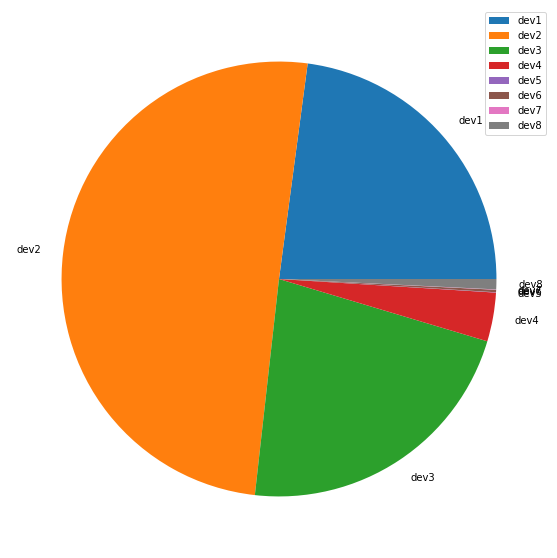

In [83]:
#make a pie plot to see distribution of different devices
cnt_dev_1 = (df["device_1.0"]).sum()
cnt_dev_2 = (df["device_2.0"]).sum()
cnt_dev_3 = (df["device_3.0"]).sum()
cnt_dev_4 = (df["device_4.0"]).sum()
cnt_dev_5 = (df["device_5.0"]).sum()
cnt_dev_6 = (df["device_6.0"]).sum()
cnt_dev_7 = (df["device_7.0"]).sum()
cnt_dev_8 = (df["device_8.0"]).sum()

y = np.array([cnt_dev_1, cnt_dev_2, cnt_dev_3, cnt_dev_4, cnt_dev_5, cnt_dev_6, cnt_dev_7, cnt_dev_8])
mylabels = ["dev1", "dev2", "dev3", "dev4", "dev5", "dev6", "dev7", "dev8"]


plt.pie(y, labels = mylabels)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.legend()
plt.show() 

we see there are mainly devices 1, 2, 3, and 4. Other devices can be grouped into one column. 

In [84]:
def group_dummies_dev(new_col, dev_list, df):
    df[new_col] = df[dev_list].sum(axis =1)
    return df

other_dev = ["device_5.0", "device_6.0", "device_7.0", "device_8.0"]
df = group_dummies_dev("dev_other", other_dev, df)


df = drop_cols(["device_5.0", "device_6.0", "device_7.0", "device_8.0"], df)

# df = df.drop(columns = ["device_5.0", "device_6.0", "device_7.0", "device_8.0"] ,inplace=False)

<p>
    <u>Exploring internet browser</u>:<br>
To optimize e-commerce stores for online shopping, we need to know how users view the store. This means we’ll need to understand the most popular browsers used by consumers. 
<br>
possible Web - Browser Types are:
<ul>
<li>Internet Explorer</li>
<li>Google Chrome</li>
<li>Mozilla Firefox</li>
<li>Safari</li>
<li>Opera</li>
<li>Konqueror</li>
<li>Lynx</li>
</ul>
By checking online, we discovered that most popular browsers are (desc order): <u>Chrome, Safari, Firefox, Edge, Samsung Internet and Opera</u>. Therefore, we excpect to see them in the data.

<u>By looking at the raw data, we notice there are mainly 4 types of internet browsers: Safari, Edge, Chrome and unknown type which will be labeled as internet browser</u>.
</p>

In [85]:
#transofrm browser column into 4 different browser columns only
def browsers(df):
    df["internet_browser_copy"] = df["internet_browser"]
    df = pd.get_dummies(df, columns=['internet_browser'])
    #find all type of browsers
    chrome_cols = [x for x in df.columns if x.startswith('internet_browser_chrome')]
    browser_cols = [x for x in df.columns if x.startswith('internet_browser_browser')]
    safari_cols = [x for x in df.columns if x.startswith('internet_browser_safari')]
    edge_cols = [x for x in df.columns if x.startswith('internet_browser_edge')]
    df['chrome_browser'] = df[chrome_cols].sum(axis=1)
    df['browser_browser'] = df[browser_cols].sum(axis=1)
    df['safari_browser'] = df[safari_cols].sum(axis=1)
    df['edge_browser'] = df[edge_cols].sum(axis=1)
    #delete repeated cols
    drop_browser = [x for x in df.columns if x.startswith('internet_browser_')]
    # df = drop_cols(["drop_browser"], df)
    df = df.drop(columns = drop_browser,inplace=False)
    return df

df = browsers(df)

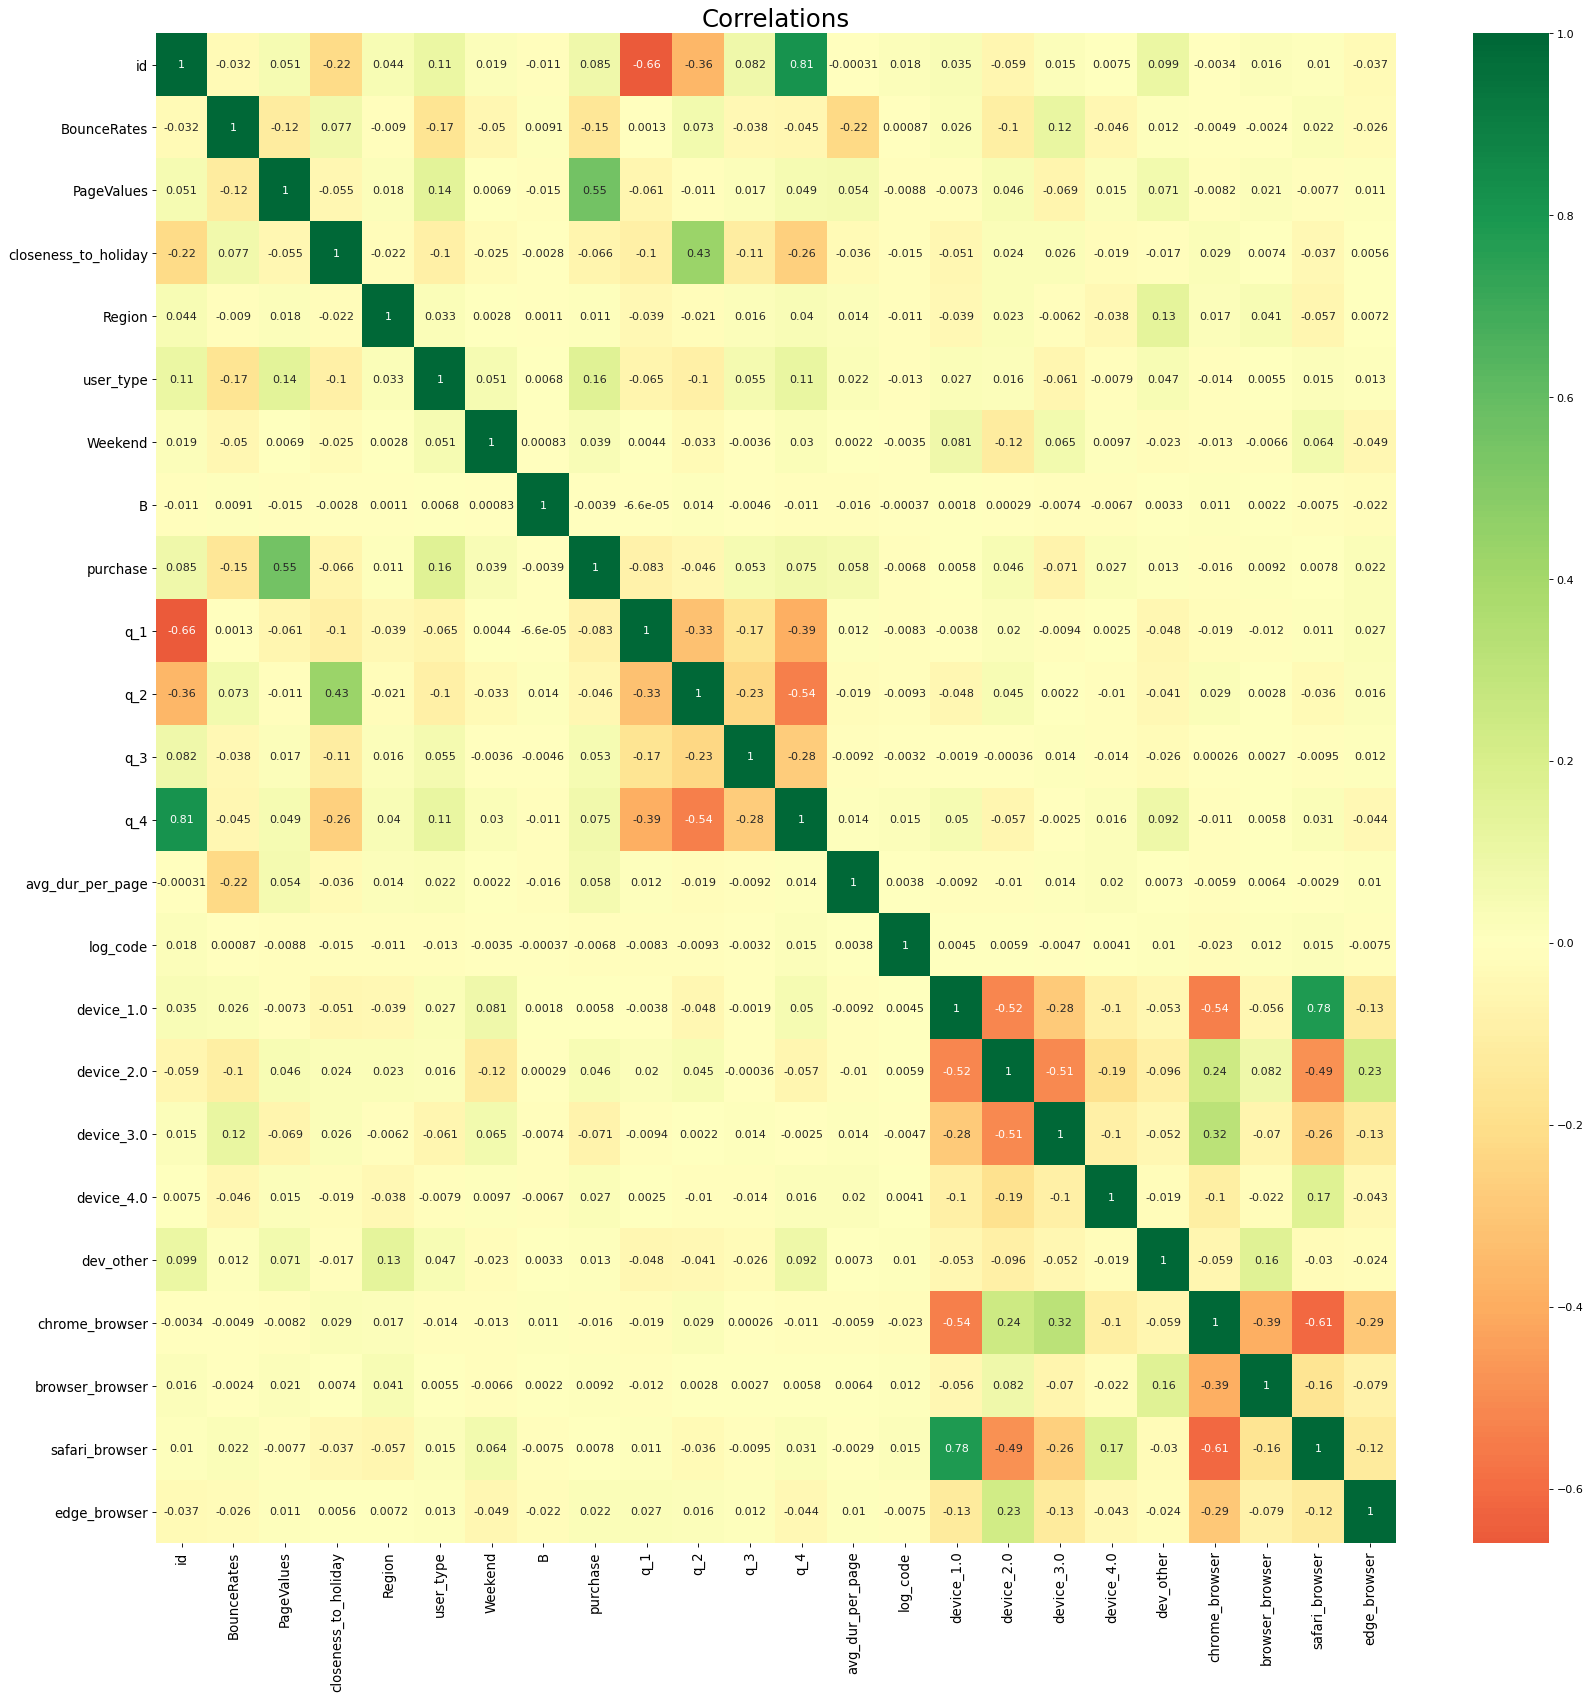

In [86]:
#find correlations between 
plt.figure(figsize=(25,25), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlations', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We shall use our previous knowledge about different type of internet browsers and devices. <br>
1. We see a positive correlation between device2 and edge. As Edge is mainly available for Windows desktop, we assums device2 is a PC. We also understand many people buy via PC, as device2 has the biggest chunk of our users pie graph.
2. By looking at device1, we find it has a negative corrleation with chrome and a very strong positive one with safari. Safari is used only by Mac users. We note that. 
3. There is a correlation between device3 and Chrome. Chrome is used by Android smartphones or PC. <br>

We could consider engineering new featuers that are combined by browser + device, to get a more detailed profile. <br>
<u>Note</u>: we decided to drop this lead as it was a matter of trade-offs between a more complex, packed-with-feauters kind of model that might result in overfitting vs. a rather more simple yet faster model. Both seemed to have an almost similiar prediction.

### Region

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

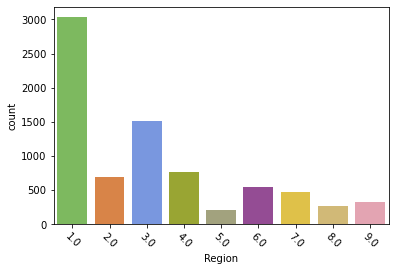

In [87]:
Region_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

sns.countplot(x='Region',  data=df, palette=Region_type_colors)
 
# Rotate x-labels
plt.xticks(rotation=-45)

There seems to be 9 Regions, where Region1 seems to be the biggest one. Region3 seems to be not as big, but people tend to buy more proprtionally. We decide to count how big the regions are, in order to group some of them together to Region "other".

In [88]:
df = pd.get_dummies(df, columns=['Region'])

In [89]:
# check how many values in each Region  
print(df["Region_1.0"].sum())
print(df["Region_2.0"].sum())
print(df["Region_3.0"].sum())
print(df["Region_4.0"].sum())
print(df["Region_5.0"].sum())
print(df["Region_6.0"].sum())
print(df["Region_7.0"].sum())
print(df["Region_8.0"].sum())
print(df["Region_9.0"].sum())

3031
700
1513
765
212
546
477
273
326


In [90]:
def group_dummies_Region(new_col, reg_list, df):
    df[new_col] = df[reg_list].sum(axis =1)
    return df

#all regions under 1000 counts become one region "other"

other_reg = ["Region_2.0", "Region_2.0", "Region_4.0", "Region_5.0", "Region_6.0", "Region_7.0", "Region_8.0", "Region_9.0"]
df = group_dummies_Region("Region_other", other_reg, df)

df = df.drop(columns = other_reg ,inplace=False)

### ID
id column is unnecessary to models' performance and brings no added significance to the model.

In [91]:
df = df.drop(columns = ["id"] ,inplace=False)

### B

<u>In order to know if B is normally distrubted, we use QQPlot.</u> - another popular plot for checking the distribution of a data sample.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups, called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

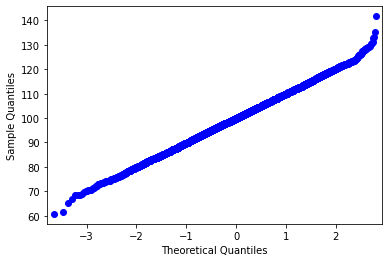

In [92]:
# QQ Plot
# generate univariate observations
# q-q plot
qqplot(df["B"], line='s')
pyplot.show()

QQplot seems to be pretty normally distributed. This helps us figure out how to fill in missing values.

Fill in missing values choosing values from a normal distribution.
We create a series of random variables with the same length as your dataframe, then apply fillna.

In [93]:
df["B"] = df["B"].fillna(pd.Series([np.random.normal() for x in range(len(df["B"]))]))

In [94]:
#in case of any additional nans
df = replace_nans("B", df["B"].median(), df)
df = replace_inf("B", df["B"].median(), df)

In [95]:
#normalize B
df = make_between_zero_to_one("B", df)
df["B"].describe()


count    7859.000000
mean        0.703212
std         0.076090
min        -0.021092
25%         0.656897
50%         0.704255
75%         0.751817
max         1.000000
Name: B, dtype: float64

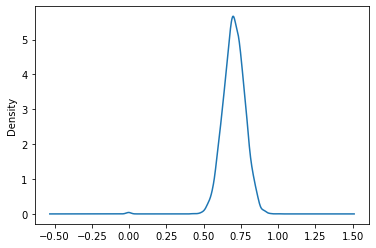

In [96]:
df["B"].plot.density()

In [97]:
#thought about using Box and Cox but have non positive values, therefore not possible
# import numpy as np
# from scipy import stats
# from scipy.stats import boxcox 
# transformed_data, best_lambda = boxcox(df["B"]) 

# #plot the distribution of the transformed data values
# sns.distplot(transformed_data, hist=False, kde=True) 

### A
column A is an an anonymouse column. 

In [98]:
#what values in column A
df["A"].value_counts()

c_2        2152
c_1        1441
c_3        1341
c_4         671
c_13        432
           ... 
c_20_23       1
c_20_49       1
c_17          1
c_20_33       1
c_20_83       1
Name: A, Length: 92, dtype: int64

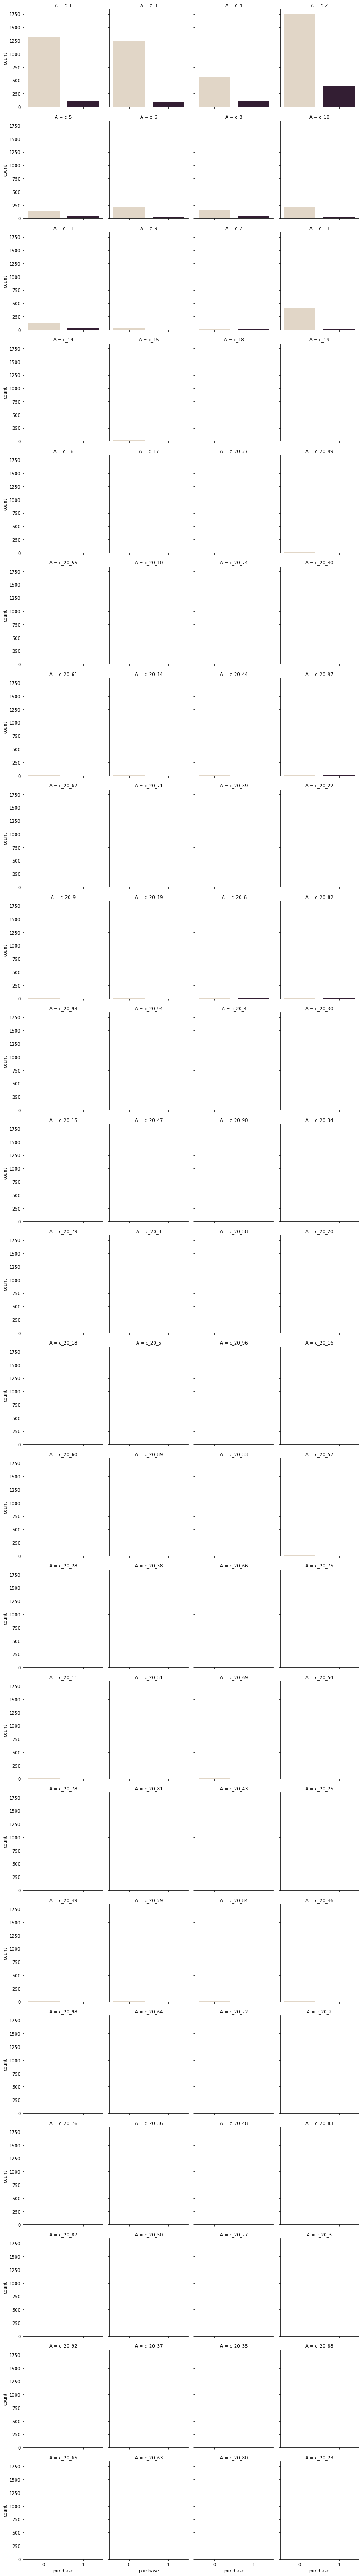

In [99]:
#find how different values effect purchase 
g = sns.catplot("purchase", col="A", col_wrap=4,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette="ch:.25")
fig.suptitle('sf')
plt.show()

By looking at the graph, we can assume that <u>column A is page number in the current website</u>. User might visit certain pages more, which might lead to a purchase. <br>

We can understand <u>there might be a connection between column A and column C (log codes)</u>, as certrain page return different log codes. Let's continue exploring column A and decicde wether we should use it, or continue using C column only.
<br>
We decide to divide the column to different numbers. For example: c_1 is 1, and c_20_10 become page_number_20. c_20_10 means page 20 might redirect the user back to page 10. <br>
<u>Note</u>: after iterating over the 4 models, we found that the Region column doesn't help the model, therefore decided to drop it. 

In [100]:
#divide to site page number
df['page_number'] = df['A'].str.split('_').str[1]
df

,BounceRates,PageValues,closeness_to_holiday,user_type,Weekend,A,B,purchase,q_1,q_2,q_3,q_4,avg_dur_per_page,log_code,device_1.0,device_2.0,device_3.0,device_4.0,dev_other,chrome_browser,browser_browser,safari_browser,edge_browser,Region_1.0,Region_3.0,Region_other,page_number
0,1.000000,0.0,0.0,-1.0,0.0,c_1,0.838748,0,1,0,0,0,0.000000,1.0,1,0,0,0,0,0,0,1,0,1,0,0,1
1,1.000000,0.0,0.0,-1.0,0.0,c_3,0.799791,0,1,0,0,0,0.000000,-1.0,0,0,0,1,0,0,0,1,0,0,0,1,3
2,0.100000,0.0,0.0,-1.0,1.0,c_4,0.857287,0,1,0,0,0,0.038337,1.0,0,0,1,0,0,0,1,0,0,1,0,0,4
3,0.078947,0.0,0.0,-1.0,0.0,c_3,0.661425,0,1,0,0,0,0.005951,1.0,0,1,0,0,0,1,0,0,0,1,0,0,3
4,1.000000,0.0,0.4,-1.0,0.0,c_3,0.702337,0,1,0,0,0,0.000000,1.0,0,1,0,0,0,0,0,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10473,0.000000,0.0,0.0,-1.0,0.0,c_1,0.672359,0,0,0,0,1,0.021692,-1.0,0,1,0,0,0,1,0,0,0,1,0,0,1
10475,0.000000,0.0,0.0,-1.0,1.0,c_8,0.701712,0,0,0,0,1,0.068292,1.0,0,0,1,0,0,1,0,0,0,1,0,0,8
10476,0.416667,0.0,0.0,-1.0,1.0,c_13,0.666153,0,0,0,0,1,0.022513,0.0,0,0,1,0,0,1,0,0,0,1,0,0,13
10477,0.000000,0.0,0.0,-1.0,0.0,c_11,0.768469,0,0,0,0,1,0.016245,-1.0,0,1,0,0,0,1,0,0,0,0,1,0,11


In [101]:
#see groups
df["page_number"].value_counts()

2     2152
1     1441
3     1341
4      671
13     432
10     250
6      238
8      212
5      183
11     161
20     138
15      29
9       27
7       26
19      11
18       7
14       6
16       2
17       1
Name: page_number, dtype: int64

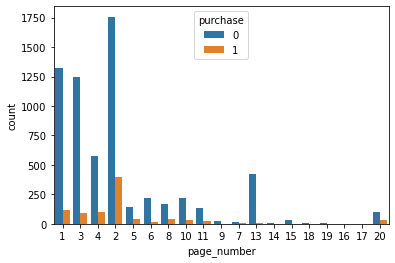

In [102]:
#show page numbers in comprasion with purchase
#sns.histplot(data=df, x="page_number", hue="purchase", multiple="stack")
sns.countplot(x="page_number",hue= 'purchase', data = df)

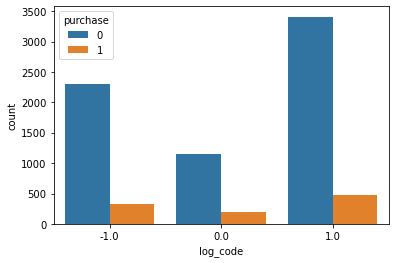

In [103]:
#show log code in comprasion with purchase
#sns.histplot(data=df, x="log_code", hue="purchase", multiple="stack")
sns.countplot(x="log_code",hue= 'purchase', data = df)

we assume that there might be a connection between certain pages and log codes (telling similiar enough information). Therefore, we decide to drop col A and page_number. <br>
<u>Note</u>: we didn't find the strong connection between log_code and page_number as we would've expected but we got to know our data better.

In [104]:
df = make_dummies("page_number", df)

In [105]:
#grouping pages 5-20 as they have not many values

def group_dummies_page(new_col, page_list, df):
    df[new_col] = df[page_list].sum(axis =1)
    return df

#list of 5-20 
number_list = list(range(5,21))
number_list.remove(12) #page 12 doesn't exist
page_list = []

for number in number_list:
    page_list.append("page_number_"+str(number))

df = group_dummies_page("other_number", page_list, df)

In [106]:
#droping duplicates
df = drop_cols(page_list,df)

after iterating over these new dummies, model prediction got worse. Therefore, we decide to drop them. 

In [107]:
df

,BounceRates,PageValues,closeness_to_holiday,user_type,Weekend,A,B,purchase,q_1,q_2,q_3,q_4,avg_dur_per_page,log_code,device_1.0,device_2.0,device_3.0,device_4.0,dev_other,chrome_browser,browser_browser,safari_browser,edge_browser,Region_1.0,Region_3.0,Region_other,page_number_1,page_number_2,page_number_3,page_number_4,other_number
0,1.000000,0.0,0.0,-1.0,0.0,c_1,0.838748,0,1,0,0,0,0.000000,1.0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
1,1.000000,0.0,0.0,-1.0,0.0,c_3,0.799791,0,1,0,0,0,0.000000,-1.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
2,0.100000,0.0,0.0,-1.0,1.0,c_4,0.857287,0,1,0,0,0,0.038337,1.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
3,0.078947,0.0,0.0,-1.0,0.0,c_3,0.661425,0,1,0,0,0,0.005951,1.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,1.000000,0.0,0.4,-1.0,0.0,c_3,0.702337,0,1,0,0,0,0.000000,1.0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10473,0.000000,0.0,0.0,-1.0,0.0,c_1,0.672359,0,0,0,0,1,0.021692,-1.0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
10475,0.000000,0.0,0.0,-1.0,1.0,c_8,0.701712,0,0,0,0,1,0.068292,1.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
10476,0.416667,0.0,0.0,-1.0,1.0,c_13,0.666153,0,0,0,0,1,0.022513,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
10477,0.000000,0.0,0.0,-1.0,0.0,c_11,0.768469,0,0,0,0,1,0.016245,-1.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [108]:
df = df.drop(columns = ["page_number_1","page_number_2", "page_number_3", "page_number_4", "other_number"] ,inplace=False)

In [109]:
df = df.drop(columns = ["A"] ,inplace=False)

### closeness to holiday
we found that closeness to holiday changes between different regions.

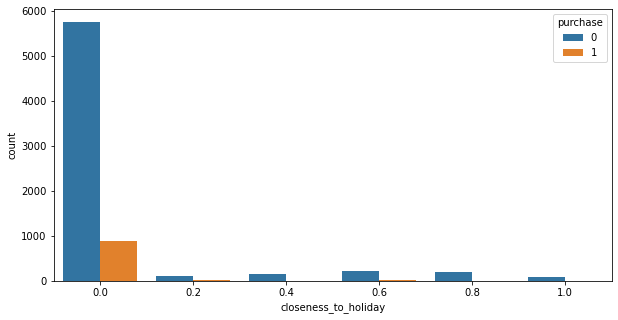

In [110]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="closeness_to_holiday",hue= 'purchase', data = df)
plt.show()

Looking at the data, we see that most of the time closeness to holiday is 0, meaning usually there's no holiday approaching. Therefore, we decide to change the column to -1 and 1. 
1 represents "No holiday" while -1 represents "Holiday". It seems as though people tend to buy more during non-holiday days. This makes sense, as there  are in general more days without holidays. <br>
NaNs are filled with main value which is now 1. 

In [111]:
def change_to_holiday(col_name, log_list, df):
    df[col_name] = df[col_name].replace({log_list[0]: 1, log_list[1]: -1, 
                                         log_list[2]: -1, log_list[3]: -1, log_list[4] :-1, log_list[5] :-1})
    return df
    
closeness_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
df = change_to_holiday("closeness_to_holiday", closeness_list, df)

In [112]:
df = replace_nans("closeness_to_holiday", 1, df)

### PageValues

In [113]:
#normalize pageValues
df = make_between_zero_to_one("PageValues", df)
# df["PageValues"] = df["PageValues"]/df["PageValues"].max()

In [114]:
df["PageValues"].describe()

count    7840.000000
mean        0.014311
std         0.051703
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: PageValues, dtype: float64

In [115]:
#therefore fill NaNs with 0, which is main value
df = replace_nans("PageValues", 0, df)
# df["PageValues"].fillna(value=0, inplace=True)

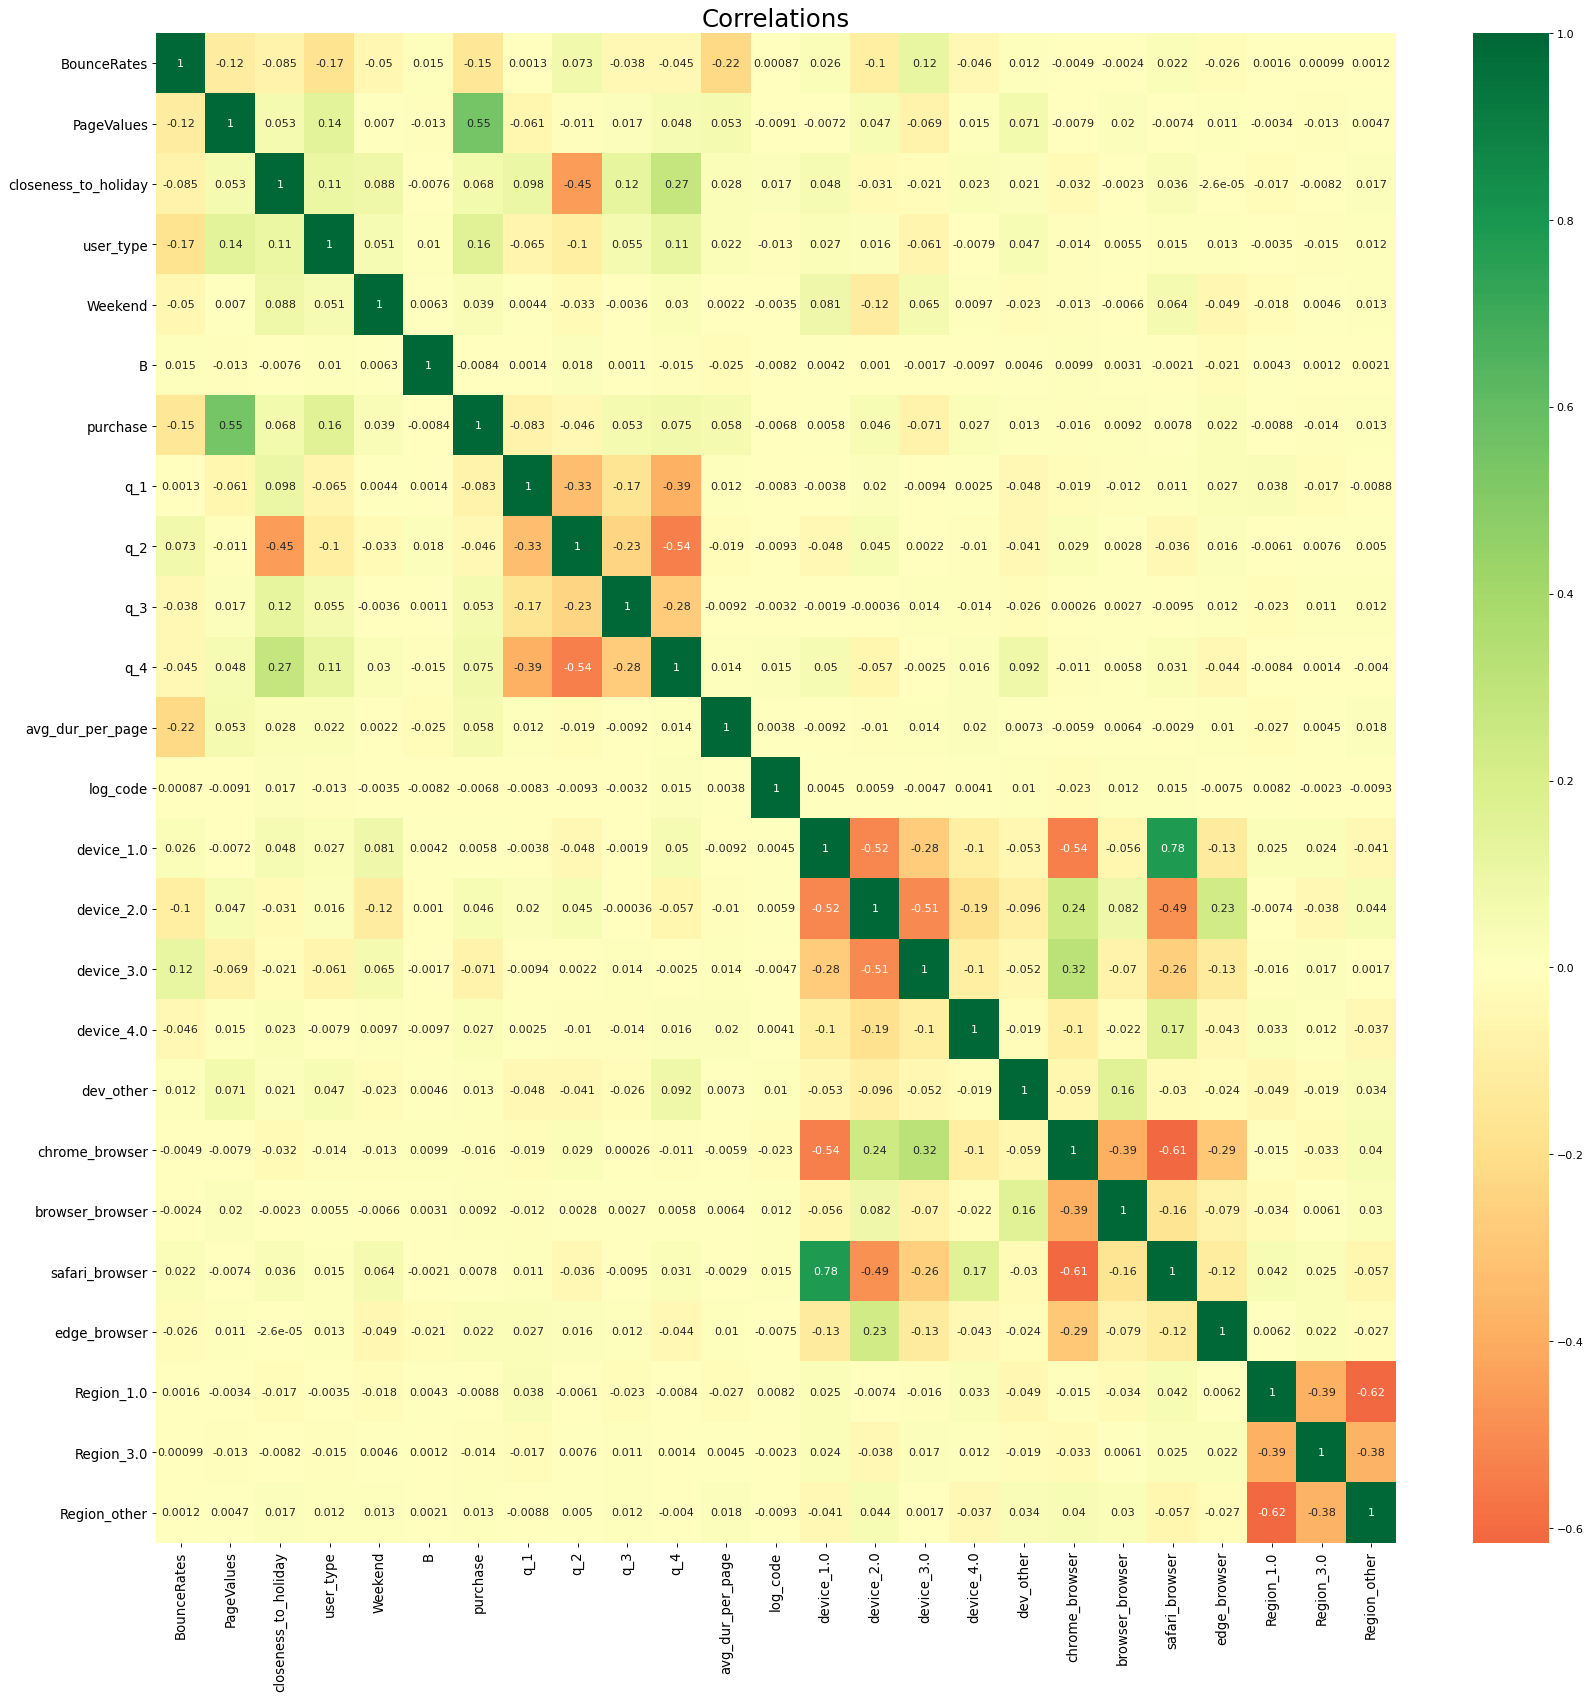

In [116]:
#find correlations between 
plt.figure(figsize=(25,25), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlations', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We wanted to avoid many dummy/excess featuers and therefore tried to drop those that have a high correlation (>-+0.50).
We saw that this try didn't improve our prediction and even caused overfitting. Therefore we decided not to go that road, but left them in comment.  

In [117]:
# df["mac_user"] = df["device_1.0"]

In [118]:
# df = df.drop(columns = ["safari_browser", "device_1.0"] ,inplace=False)

In [119]:
# df["chrome_user"] = df["device_2.0"]

In [120]:
# df = df.drop(columns = ["chrome_browser", "device_2.0"] ,inplace=False)

In [121]:
# df['Region_other'] = df['Region_other'].replace({1:-1})

In [122]:
# region_lst = ["Region_other", "Region_1.0"]
# df = comb_cols(region_lst, "Region_1.0", df)

In [123]:
# df['mac_user'] = df['mac_user'].replace({1:-1})

In [124]:
# user_lst = ["mac_user", "chrome_user"]
# df = comb_cols(user_lst, "chrome_user", df)

In [125]:
# df['q_4'] = df['q_4'].replace({1:-1})
# q_lst = ["q_4", "q_2"]
# df = comb_cols(q_lst, "q_4", df)

In [126]:
# df = df.drop(columns = ["Region_other", "mac_user", "q_2"] ,inplace=False)

We decided to drop some columns with high correlations, as they didn't change the model too much. 

In [127]:
df = df.drop(columns = ["Region_1.0", "Region_3.0", "Region_other", "device_1.0", "device_2.0", "q_2", "chrome_browser"] ,inplace=False)

### Reduce dimensions

We would reduce the dimentions of the data set in order to prevent the following:
1. The Curse of the Dimension - The larger the number of features, the larger the dimension of the problem, which reduces the density of observations.
And impairs the statistical significance of the various methods.
2. When we make a prediction, there will be dependence on many components, which makes the classification process difficult.
2. Correlative properties do not add information
3. High complexity and long calculation time
4. The larger the number of features, the model will use them for prediction, but the predictive power of the model will not come
Expressed in Test, which increases the risk of overfitting.

In [128]:
#copy just in case
df2 = df.copy()

In [129]:
# def get_principal_components(X: np.array, p: float) -> np.array:
#     """
#     Returns array of principal components explaining (100*p)% of the variance
#     X: 2d numpy array of data we want to apply PCA on. 
#     p: float in the range (0,1]. The proportion of variance explained by components
#     """
#     #initialize PCA
#     pca = PCA(n_components = p)
#     #fit the model with the data
#     pca.fit(X)
#     return pca.components_

####  Calculating information gain for each feature
We will now use mutual info classif (sklearn library) to learn more about how each feature contributes more information.

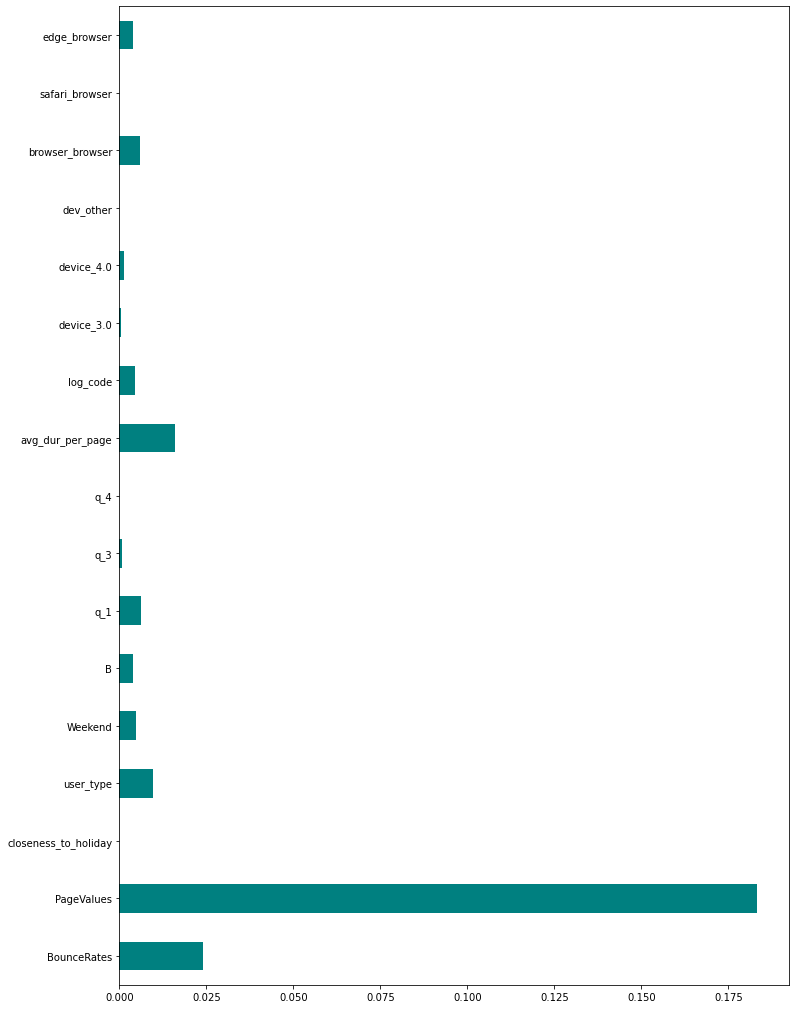

In [130]:
importances = mutual_info_classif(df2.drop(columns = ["purchase"] ,inplace=False), df2["purchase"])
plt.figure(figsize=(12,18))
feat_importances = pd.Series(importances, df2.drop(columns = ["purchase"] ,inplace=False).columns[:len(df2.drop(columns = ["purchase"] ,inplace=False).columns)])
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

This plot didn't provide us with too much information and doesn't look informative enough. 
But, we did see that the PageValues column has a very high importance. In addition to this plot, we already saw relativly high correlation (0.55%) between PageValues and Purchase. PageValues column helps us predict with very high precentage wether the user will purchase or not.    

We choose to PCA in order to reduce dimensions. We left also our tries in comment.

In [131]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_validation = sc.fit_transform(X_validation)
# pca = PCA()
# X_train = pca.fit_transform(X_train)
# X_validation = pca.transform(X_validation)
# explained_variance = pca.explained_variance_ratio_
# explained_variance
# pca = PCA(n_components = 11)
# X_train = pca.fit_transform(X_train)
# X_validation = pca.transform(X_validation)

In [132]:
# from sklearn.decomposition import PCA
# def get_principal_components(X: np.array, p: float) -> np.array:
#     """
#     Returns array of principal components explaining (100*p)% of the variance
#     X: 2d numpy array of data we want to apply PCA on. 
#     p: float in the range (0,1]. The proportion of variance explained by components
#     """
    
#     X_copy = X.copy()
#     #initialize PCA
#     pca = PCA(n_components = p)
#     #fit the model with the data
#     pca.fit(X_copy)
#     return pca.components_

# components = get_principal_components(df2.drop(columns = ["purchase"] ,inplace=False),0.99)

# print(f'number of components which preserve at least 99% of the variance: {len(components)}')

We would like to choose from all the features those that have maximum explained variability. We will use PCA,
The function will receive sets / sets of data and generate a PCA object with the selected cumulative variable explanation (95%).

In [133]:
def n_components (x_train, plot = False):
    pca = PCA(n_components = x_train.shape[1], random_state = 1).fit(x_train)
    if plot:
        plt.figure(300)
        plt.title("Number of Components in PCA")
        plt.xlabel('Components')
        plt.ylabel('Precented Of Explained Variance')
        plt.plot(pca.explained_variance_ratio_.cumsum())
        plt.show()
    return np.sum(pca.explained_variance_ratio_.cumsum() < 0.99) + 1

In [134]:
def pca_plot(train):
#    train=train.drop(columns=['purchase'])

    X_mm = MinMaxScaler().fit_transform(train)
    X_s= StandardScaler().fit_transform(train)
    X_q = QuantileTransformer().fit_transform(train)

    pca_mm = PCA(n_components= X_mm.shape[1], random_state=1)
    pca_s = PCA(n_components= X_s.shape[1], random_state=1)
    pca_q = PCA(n_components=X_s.shape[1],random_state = 1)
    
    pca_mm.fit(X_mm)
    pca_s.fit(X_s)
    pca_q.fit(X_q)

    plt.figure(figsize=(16,8))
    plt.plot(pca_mm.explained_variance_ratio_.cumsum(), 'r', label= 'MinMaxScaler')
    plt.plot(pca_s.explained_variance_ratio_.cumsum(), 'b', label= 'StandardScaler')
    plt.plot(pca_q.explained_variance_ratio_.cumsum(), 'g', label= 'QuantileTransformer')    
    plt.xlabel('Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()
    print ("Explained_variance_ratio")
    print("MinMaxScaler:", np.sum(pca_mm.explained_variance_ratio_.cumsum()<0.99)+1)
    print("StandardScaler:", np.sum(pca_s.explained_variance_ratio_.cumsum()<0.99)+1)
    print('QuantileTransformer:', np.sum(pca_q.explained_variance_ratio_.cumsum()<0.99)+1)
    return np.sum(pca_mm.explained_variance_ratio_.cumsum()<0.99)+1, np.sum(pca_s.explained_variance_ratio_.cumsum()<0.99)+1,np.sum(pca_q.explained_variance_ratio_.cumsum()<0.99)+1

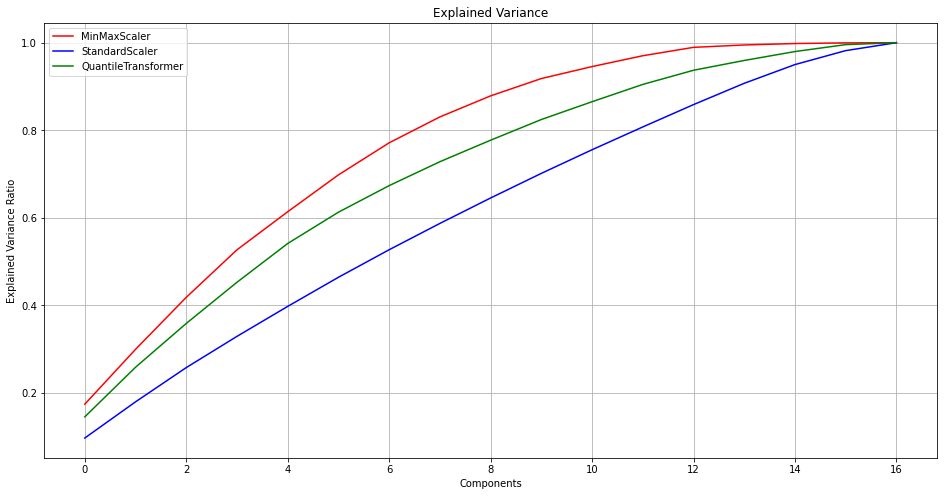

Explained_variance_ratio
MinMaxScaler: 14
StandardScaler: 17
QuantileTransformer: 16


(14, 17, 16)

In [135]:
pca_plot(df2.drop(columns = ["purchase"] ,inplace=False))

The above plot shows the explained variance of our components. MinMaxSclaer has the best variance for our dataset, therefore we decide to choose this method for our corrleation map in order to find the best featuers (which explain our hypothesis).

In [136]:
def correlation_mat (x_data):
    corr_matrix=x_data.corr()
    ## Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    ## Find index of feature columns with correlation greater than 0.75
    feat_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    is_corr = [column for column in upper.columns if any(upper[column] > 0.5)]
    f, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(corr_matrix, vmax=.8, square=True)
    plt.title('Features Correlation')
    plt.show()
    print("Features that were drop with correlation greater than 0.95: "+ str(feat_drop))
    print("Features  with correlation greater than 0.5: "+ str(is_corr))    
    print("Number of features that were drop: "+str(len(feat_drop)))
    print("Number of features that were left: "+str(x_data.shape[1]-len(feat_drop)))
    return feat_drop

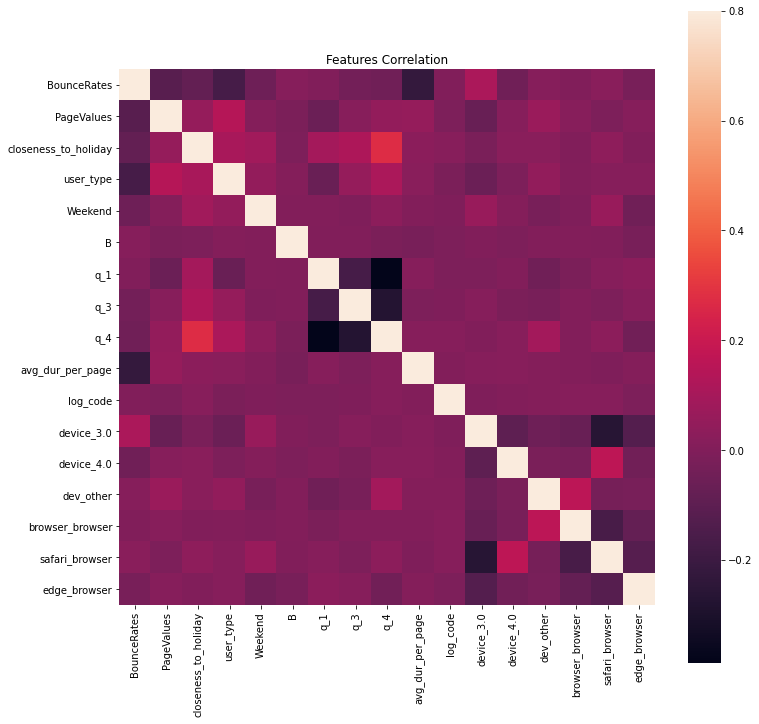

Features that were drop with correlation greater than 0.95: []
Features  with correlation greater than 0.5: []
Number of features that were drop: 0
Number of features that were left: 17


,BounceRates,PageValues,closeness_to_holiday,user_type,Weekend,B,q_1,q_3,q_4,avg_dur_per_page,log_code,device_3.0,device_4.0,dev_other,browser_browser,safari_browser,edge_browser
0,1.000000,0.0,1.0,-1.0,0.0,0.838748,1,0,0,0.000000,1.0,0,0,0,0,1,0
1,1.000000,0.0,1.0,-1.0,0.0,0.799791,1,0,0,0.000000,-1.0,0,1,0,0,1,0
2,0.100000,0.0,1.0,-1.0,1.0,0.857287,1,0,0,0.038337,1.0,1,0,0,1,0,0
3,0.078947,0.0,1.0,-1.0,0.0,0.661425,1,0,0,0.005951,1.0,0,0,0,0,0,0
4,1.000000,0.0,-1.0,-1.0,0.0,0.702337,1,0,0,0.000000,1.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10473,0.000000,0.0,1.0,-1.0,0.0,0.672359,0,0,1,0.021692,-1.0,0,0,0,0,0,0
10475,0.000000,0.0,1.0,-1.0,1.0,0.701712,0,0,1,0.068292,1.0,1,0,0,0,0,0
10476,0.416667,0.0,1.0,-1.0,1.0,0.666153,0,0,1,0.022513,0.0,1,0,0,0,0,0
10477,0.000000,0.0,1.0,-1.0,0.0,0.768469,0,0,1,0.016245,-1.0,0,0,0,0,0,0


In [137]:
new_pre = df2.drop(columns = ["purchase"] ,inplace=False)
drop_feat=correlation_mat(new_pre)
new_pre.drop(columns = drop_feat)

As a result of the correlation matrix, there are no featuers with a correlation higher than 95% - our threshold. Therefore, no featuers were dropped.

### Part 3 - Building the models


In [138]:
#splitting the data to train and validation sets
y_sample = df2["purchase"]
X_train, X_validation, y_train, y_validation = train_test_split(df2.drop(columns = ["purchase"] ,inplace=False), y_sample, test_size=0.2, random_state=1)

### Desicion Tree

In [139]:
clf = DecisionTreeClassifier()
y_sample = df2["purchase"]
params = {  'criterion': ['gini', 'entropy'],
            'max_depth': [4, 10],
            'min_samples_split' : [2, 10],
            'splitter': ['best'],
            'max_features' : [10, 20]
         }

grids_dt = GridSearchCV(clf, params, scoring='roc_auc', cv=2)
grids_dt.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(grids_dt.best_params_)
print(grids_dt.best_score_)

Best parameters set found on development set:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 10, 'min_samples_split': 2, 'splitter': 'best'}
0.9290569431551681


In [140]:
clf1 = DecisionTreeClassifier(**grids_dt.best_params_)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=10)

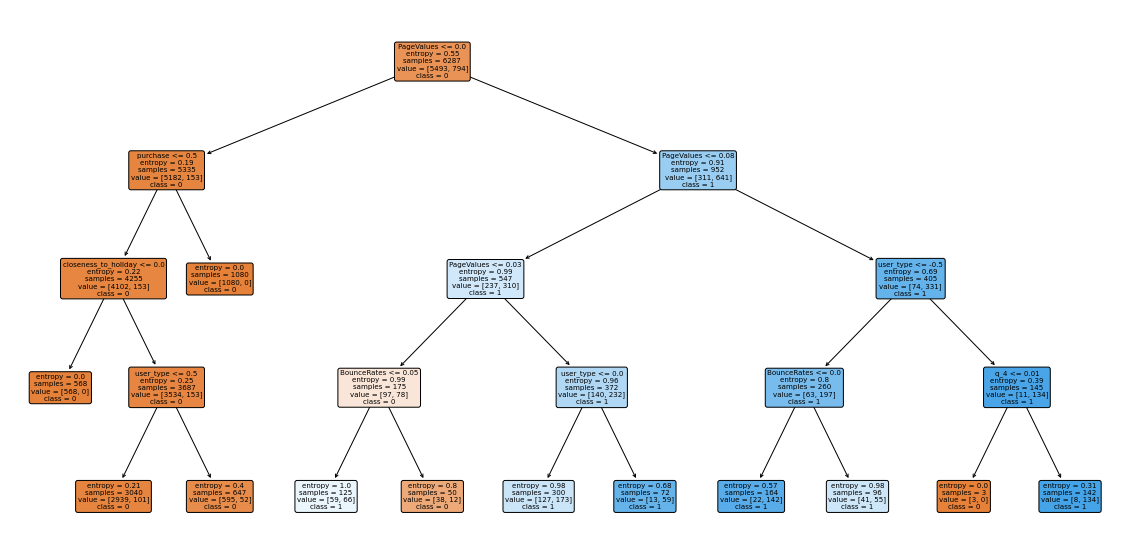

In [141]:
plt.figure(figsize=(20,10))
dot_data  = plot_tree(clf1, 
                    feature_names = df2.columns,
                    class_names = ["0","1"],
                    rounded = True, proportion = False, impurity = True,
                    label='all', precision = 2, filled = True) 

### Logistic regression

In [142]:
powers = range(-10, 1)
Cs = [10**p for p in powers]

tuning_params_lr = {"C" : Cs, "penalty":["l1","l2"], "solver" : ['saga', 'liblinear']}
grid_lr = GridSearchCV(LogisticRegression(), tuning_params_lr, cv=2, scoring = 'roc_auc')
grid_lr.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(grid_lr.best_params_)
print(grid_lr.best_score_)

Best parameters set found on development set:
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.9148058197275892


In [143]:
clf2 = LogisticRegression(**grid_lr.best_params_)
clf2.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

### GaussianNB

In [144]:
clf3 = GaussianNB()
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_validation)

### Random forest

In [145]:

clf = RandomForestClassifier(random_state=0)

params = {'n_estimators': [65,75,85],
            'criterion': ['gini', 'entropy'],
            'max_depth': [50, 100, 200],
            'min_samples_leaf' : [10, 50],
            'max_features' : [4, 8]
         }

grids_rf = GridSearchCV(clf, params, scoring='roc_auc', cv=2)
grids_rf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(grids_rf.best_params_)
print(grids_rf.best_score_)

Best parameters set found on development set:
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 8, 'min_samples_leaf': 50, 'n_estimators': 65}
0.9390876273227555


In [146]:
np.random.seed(5)
clf4 = RandomForestClassifier(**grids_rf.best_params_)
clf4.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features=8,
                       min_samples_leaf=50, n_estimators=65)

### Part 4 - Model evaluation

In [147]:
y_pred = clf4.predict(X_validation)     
cf_matrix = confusion_matrix(y_validation, y_pred)
    
def plot_confusion_matrix(X_validation, y_validation, cf_matrix):
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(6,6))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

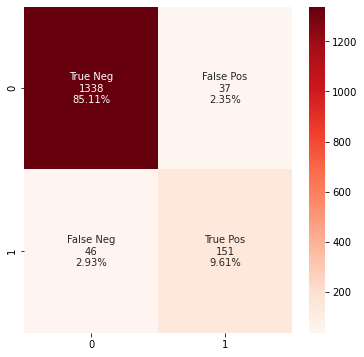

In [148]:
plot_confusion_matrix(X_validation, y_validation, cf_matrix)

#### Explaining cells in matrix

Reminder: 1 = session ended without purchase, 0 = session ended with purchase.

<u>True Pos</u> - Purchase = 1, classification = 1 means that session ended with a purchase and we classified it correctly. 

<u>False Pos</u> - Purchase = 0, classification = 1 means that session ended without a purchase and we classified it incorrectly.

<u>True Neg</u> - Purchase = 0, classification = 0 means that session ended without a purchase and we classified it correctly.

<u>False Neg</u> - Purchase = 1, classification = 0 means that session ended with a purchase and we classified it incorrectly.

We can see that less than 5.5% was classified incorrectly which means our clasification was very accurate.  

In [149]:
def KfoldPlot(X, y, clf, k):
    
    clf_name = str(clf)[:str(clf).find("(")]    
    plt.figure(figsize=(10,6))
    kf = KFold(n_splits=k, shuffle=False)
    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []
    i=1
    for train_index, validation_index in kf.split(X):

        model = clf.fit(X[train_index], y[train_index])
        prediction = model.predict_proba(X[validation_index])
        fpr, tpr, thresholds = roc_curve(y[validation_index], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i += 1
    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.3f )' % (mean_auc), lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + clf_name)
    plt.legend(loc="lower right")
    plt.show()

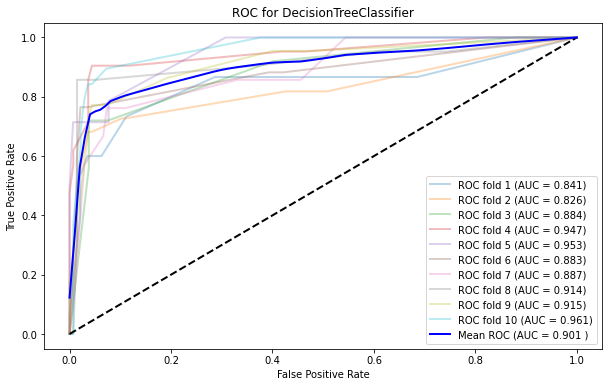

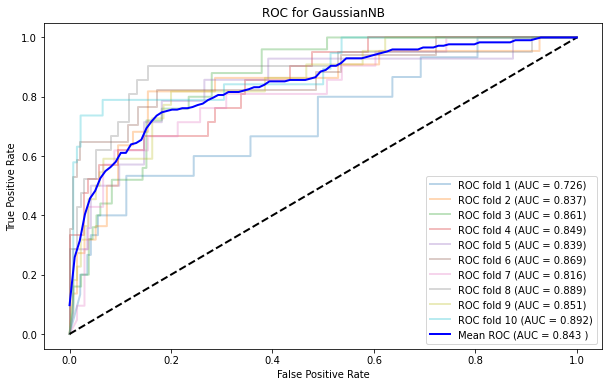

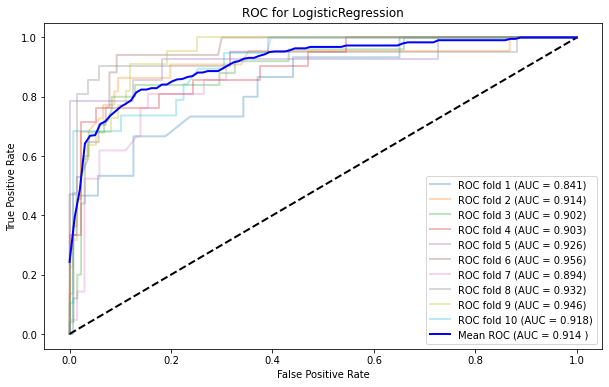

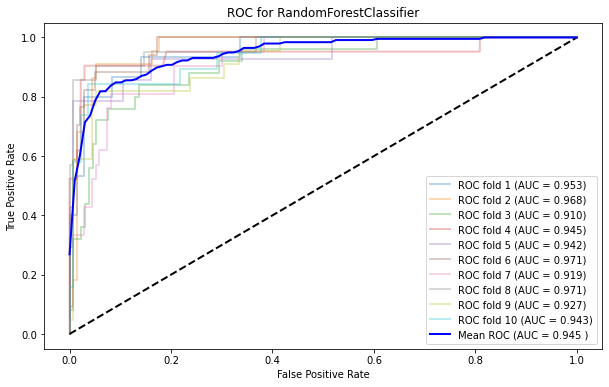

In [150]:
KfoldPlot(X_validation.values, y_validation.values, clf1, 10)
KfoldPlot(X_validation.values, y_validation.values, clf3, 10)
KfoldPlot(X_validation.values, y_validation.values, clf2, 10)
KfoldPlot(X_validation.values, y_validation.values, clf4, 10)

In [151]:
def auc_calc(clf):   
    model_name = str(clf)[:str(clf).find("(")]
    print(model_name + '\n')

    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds= roc_curve(y_train, y_prob)
    print('train AUC for {} is: {}'.format(model_name, auc(fpr,tpr)))
    
    y_prob = clf.predict_proba(X_validation)[:,1]
    fpr, tpr, thresholds= roc_curve(y_validation, y_prob)
    print('validation AUC for {} is: {}'.format(model_name, auc(fpr,tpr)))
    print('\n\n')

auc_calc(clf1)
auc_calc(clf2)
auc_calc(clf3)

np.random.seed(5)
auc_calc(clf4)

DecisionTreeClassifier

train AUC for DecisionTreeClassifier is: 0.9278004843352267
validation AUC for DecisionTreeClassifier is: 0.9267281956622058



LogisticRegression

train AUC for LogisticRegression is: 0.9214966059390449
validation AUC for LogisticRegression is: 0.9184863867097369



GaussianNB

train AUC for GaussianNB is: 0.8609741915632491
validation AUC for GaussianNB is: 0.8611610521458237



RandomForestClassifier

train AUC for RandomForestClassifier is: 0.9603607018045867
validation AUC for RandomForestClassifier is: 0.9429700046146746





<p>
A strong indicator for overfitting would be a big difference between the train and validation score. <br>
From our results, there are no major differences (all differences are less than 0.02) between the modles scores when substracting the test AUC score from the train AUc score. 

We applied some methods to prevent overfitting on the validation set by using Kfold to split our data into two sets. We used the train set to tune hyperparameters by trying multiple combinations of hyperparameters.

We used gridSearch for all the relevant models (Gaussian has no hyperparameters) in order to find best hyperparameters for each model.

We could apply some method to generlize the model to overcome overfitting such as, adding more data, streghen the regulariztion, cap the size of a tree can grow in tree based models or the amount of trees in a Random Forest.

We can see that there is no overfitting in any of the models. Yay!
</p>

Since we received the best test and train AUC rates from the RandomForest we'll use this model for our prediction

### Part 5 - The final prediction

In [152]:
test_data = pd.read_csv("test.csv")
test_ID = test_data[['id']]
test_data = test_data.drop('id', axis=1)
test_ID

,id
0,0
1,1
2,2
3,3
4,4
...,...
1846,1846
1847,1847
1848,1848
1849,1849


In [153]:
def clean_test(df):
   
    df = numeric_weekend("Weekend", df)
    df = replace_nans("Weekend", 0, df)
    df = make_month_numeric("Month", df)
    df = make_dummies('Month', df)
    df = group_dummies_months(months_list, df)
    df = drop_cols(drop_list, df)
    df = drop_cols(["D"], df)
    df = change_duration_numeric("product_page_duration", df)
    df = change_duration_numeric("info_page_duration", df)
    df = replace_nans("info_page_duration", 0, df)
    df = replace_nans("admin_page_duration", 0, df)
    df['product_page_duration'] = df.apply(lambda row : fill_product_by_formula(row, df), axis=1)
    df['product_page_duration'] = df.apply(lambda row : fill_with_product_page(row, df), axis=1)
    df['product_page_duration'] = df['product_page_duration'].replace(np.nan, 0)

    df['total_duration_full'] = df.apply(lambda row : fill_total_by_formula(row, df), axis=1)
    df = drop_cols(["total_duration"], df)
#     col = df["total_duration_full"]
#     col[col > np.percentile(col, 75)] = np.percentile(col, 75)
    df = replace_nans("num_of_admin_pages", 0, df)
    df = replace_nans("num_of_info_pages", 0, df)
    df = replace_nans("num_of_product_pages", df["num_of_product_pages"].median(), df)
    df = comb_cols(page_lst, "total_num_page", df)
    df = drop_cols(["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
             "num_of_product_pages", "product_page_duration"], df)

    df = find_avg_per_page("avg_dur_per_page", "total_duration_full", "total_num_page", df)    
    df = replace_nans("avg_dur_per_page", 0, df)
    df = replace_inf("avg_dur_per_page", 0, df)
    df["avg_dur_per_page"] = df["avg_dur_per_page"].replace([np.NaN ,np.inf, -np.inf], 0, inplace=False)
    df = drop_cols(["total_duration_full", "total_num_page"], df)

    df = make_between_zero_to_one("avg_dur_per_page", df)
   
    df = drop_cols(["ExitRates"], df)
    df = make_between_zero_to_one_multi("BounceRates", 5, df)

    df = replace_nans("BounceRates", 0, df)
    df = change_to_log_code("log_code", "C", log_list, df)
    df = replace_nans("log_code", 1, df)

    df = drop_cols(["C"], df)
   
    df = replace_user_type("user_type", user_list, df)
    df = replace_nans("user_type" ,-1, df)
       
    df = make_dummies("device", df)
    df = group_dummies_dev("dev_other", other_dev, df)
    df = drop_cols(["device_5.0", "device_6.0", "device_7.0", "device_8.0"], df)
    df = browsers(df)

    df["B"] = df["B"].fillna(pd.Series([np.random.normal() for x in range(len(df["B"]))]))
    df = replace_nans("B", df["B"].median(), df)
    df = replace_inf("B", df["B"].median(), df)

    df = make_between_zero_to_one("B", df)
    df = change_to_holiday("closeness_to_holiday", closeness_list, df)
    df = replace_nans("closeness_to_holiday", 1, df)

    df = make_between_zero_to_one("PageValues", df)

    df = replace_nans("PageValues", 0, df)
    df = df.drop(columns = ["A", "Region", "device_1.0", "device_2.0", "q_2", "chrome_browser"] ,inplace=False)

   
    return df
   
test_data = clean_test(test_data)
test_data

,BounceRates,PageValues,closeness_to_holiday,user_type,Weekend,B,q_1,q_3,q_4,avg_dur_per_page,log_code,device_3.0,device_4.0,dev_other,browser_browser,safari_browser,edge_browser
0,0.000000,0.0,1.0,-1.0,0.0,0.687853,1,0,0,0.035804,1.0,0,0,0,0,0,0
1,0.250000,0.0,1.0,-1.0,0.0,0.896143,1,0,0,0.001492,-1.0,1,0,0,0,0,0
2,1.000000,0.0,1.0,-1.0,1.0,0.700001,1,0,0,0.000000,-1.0,0,0,0,0,0,0
3,0.000000,0.0,1.0,-1.0,0.0,0.862653,1,0,0,0.017902,0.0,0,0,0,0,0,0
4,0.000000,0.0,-1.0,-1.0,0.0,0.698112,1,0,0,0.017622,-1.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,0.000000,0.0,1.0,-1.0,0.0,0.670751,0,0,1,0.013054,1.0,0,1,0,0,1,0
1847,0.000000,0.0,1.0,1.0,0.0,0.824904,0,0,1,0.024168,1.0,0,0,0,0,0,0
1848,0.000000,0.0,1.0,-1.0,0.0,0.843702,0,0,1,0.033527,1.0,0,0,0,0,1,0
1849,0.045455,0.0,1.0,-1.0,1.0,0.813320,0,0,1,0.100387,1.0,0,0,0,0,0,0


In [154]:
np.random.seed(5)
test_rf = RandomForestClassifier(**grids_rf.best_params_)
test_rf.fit(df2.drop(columns = ["purchase"] ,inplace=False), y_sample)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features=8,
                       min_samples_leaf=50, n_estimators=65)

In [155]:
y_prob = test_rf.predict_proba(test_data)[:,1]
y_prob_df = pd.DataFrame(y_prob, columns=['predict_prob'])
answer_df = pd.concat([test_ID, y_prob_df], axis=1)
answer_df.to_csv('Submission_group_4.csv', index = False)
answer_df

,id,predict_prob
0,0,0.000099
1,1,0.003450
2,2,0.002866
3,3,0.000000
4,4,0.000488
...,...,...
1846,1846,0.048812
1847,1847,0.084083
1848,1848,0.034878
1849,1849,0.051137


### Part 6 - Pipeline

Best parameters set found on development set:
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 8, 'min_samples_leaf': 50, 'n_estimators': 65}
0.9390876273227555


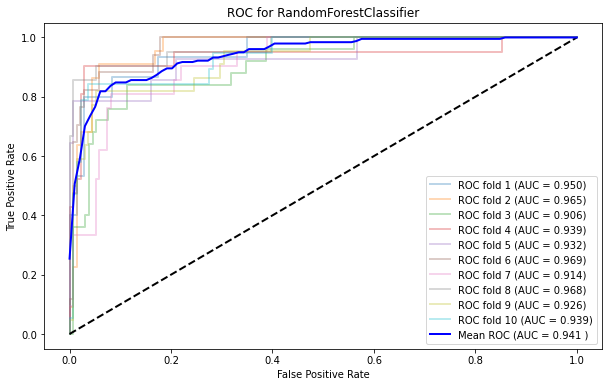

RandomForestClassifier

train AUC for RandomForestClassifier is: 0.9603607018045867
validation AUC for RandomForestClassifier is: 0.9429700046146746





,id,predict_prob
0,0,0.000099
1,1,0.003450
2,2,0.002866
3,3,0.000000
4,4,0.000488
...,...,...
1846,1846,0.048812
1847,1847,0.084083
1848,1848,0.034878
1849,1849,0.051137


In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, QuantileTransformer, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from numpy import interp
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from IPython.display import Image
from IPython.core.display import HTML 



#load csv
df = pd.read_csv('train.csv')

#pre process

#weekend
def numeric_weekend(col_name, df):
    df[col_name] = df[col_name].replace({True:1,False:0})
    return df
df = numeric_weekend("Weekend", df)

def replace_nans(col_name, value, df):
    df[col_name] = df[col_name].replace(np.nan, value)
    return df
df = replace_nans("Weekend", 0, df)

#month
def make_month_numeric(col_name, df):

    df[col_name] = df[col_name].replace({'Jan' : 1,
                      'Feb' : 2, 
                      'Mar' : 3,
                      'Apr' : 4,
                      'May' : 5,
                      'June' : 6,
                      'Jul' : 7,
                      'Aug' : 8,
                      'Sep' : 9,
                      'Oct' : 10,
                      'Nov' : 11,
                      'Dec' : 12})
    return df
df = make_month_numeric("Month", df)


def make_dummies(col_name, df):
    
    df = pd.get_dummies(df, columns=[col_name])
    return df

df = make_dummies('Month', df)


def group_dummies_months(lst, df):
    
    q1 = [lst[0], lst[1]]
    q2 = [lst[2], lst[3]]
    q3 = [lst[4], lst[5], lst[6]]
    q4 = [lst[7], lst[8], lst[9]]

    df['q_1'] = df[q1].sum(axis=1)
    df['q_2'] = df[q2].sum(axis=1)
    df['q_3'] = df[q3].sum(axis=1)
    df['q_4'] = df[q4].sum(axis=1)
    
    return df

months_list = ["Month_2.0", "Month_3.0", "Month_5.0", "Month_6.0",
"Month_7.0", "Month_8.0", "Month_9.0",
"Month_10.0", "Month_11.0", "Month_12.0"]

df = group_dummies_months(months_list, df)


#droping duplicates
def drop_cols(cols_list, df):
    for col in cols_list:
        df = df.drop(columns = [col])
    return df
drop_list = ["Month_2.0", "Month_3.0","Month_5.0", "Month_6.0","Month_7.0", 
                        "Month_8.0", "Month_9.0","Month_10.0", "Month_11.0", "Month_12.0"]
df = drop_cols(drop_list, df)

#d
df= drop_cols(["D"], df)

#product/info/admin page duration
def change_duration_numeric(col_name, df):
    df[col_name] = df[col_name].str.replace("minutes","")
    df[col_name]= df[col_name].astype(float)
    return df
df = change_duration_numeric("product_page_duration", df)
df = change_duration_numeric("info_page_duration", df) 

df = replace_nans("info_page_duration", 0, df)

df = replace_nans("admin_page_duration", 0, df)


def fill_product_by_formula(row, df):
    dur1 = row['product_page_duration']
    dur2 = row['info_page_duration']
    dur3 = row['admin_page_duration']
    dur4 = row['total_duration']
    
    if np.isnan(dur1): 
        return dur4 - dur2 - dur3
    else:
        return dur1
df['product_page_duration'] = df.apply(lambda row : fill_product_by_formula(row, df), axis=1)

def fill_with_product_page(row, df):
    
    page = row["num_of_product_pages"]
    page_median = df["num_of_product_pages"].median() 
    val_median = df["product_page_duration"].median()
    dur = row["product_page_duration"]
    
    if np.isnan(dur) and pd.notna(page):
        return page*(val_median/page_median)
    else:
        return dur
    
df['product_page_duration'] = df.apply(lambda row : fill_with_product_page(row, df), axis=1)

df['product_page_duration'] = df['product_page_duration'].replace(np.nan, 0)

def fill_total_by_formula(row, df):
    dur1 = row['product_page_duration']
    dur2 = row['info_page_duration']
    dur3 = row['admin_page_duration']
    dur4 = row['total_duration']
    
    if np.isnan(dur4): 
        return dur1 + dur2 + dur3
    else:
        return dur4
df['total_duration_full'] = df.apply(lambda row : fill_total_by_formula(row, df), axis=1)

df = drop_cols(["total_duration"], df)

df["total_duration_full"].describe()

top_75_percentage = np.percentile(df["total_duration_full"], 75)

df = df.drop(df[df["total_duration_full"] > top_75_percentage].index)

df = replace_nans("num_of_admin_pages", 0, df)
df = replace_nans("num_of_info_pages", 0, df)
df = replace_nans("num_of_product_pages", df["num_of_product_pages"].median(), df)

def comb_cols(lst, new_col, df):
    df[new_col] = df[lst].sum(axis=1)
    return df
page_lst = ["num_of_admin_pages", "num_of_info_pages", "num_of_product_pages"]
df = comb_cols(page_lst, "total_num_page", df)

df = drop_cols(["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration", 
         "num_of_product_pages", "product_page_duration"], df)

#avg_page_dur
def find_avg_per_page(new_col, total_dur_col, total_num_col, df):
    df[new_col] = df[total_dur_col]/df[total_num_col]
    return df
df = find_avg_per_page("avg_dur_per_page", "total_duration_full", "total_num_page", df)    

df = replace_nans("avg_dur_per_page", 0, df)

#in case of infs 
def replace_inf(col_name, value, df):
    df[col_name] = df[col_name].replace([np.inf, -np.inf], value)
    return df

df = replace_inf("avg_dur_per_page", 0, df)    
df["avg_dur_per_page"] = df["avg_dur_per_page"].replace([np.NaN ,np.inf, -np.inf], 0, inplace=False)

df = drop_cols(["total_duration_full", "total_num_page"], df)

def make_between_zero_to_one(col_name, df):
    df[col_name] = df[col_name]/df[col_name].max()
    return df

df = make_between_zero_to_one("avg_dur_per_page", df)

#Bounce/ExitRates
df = drop_cols(["ExitRates"], df)

def make_between_zero_to_one_multi(col_name, num, df):
    df[col_name] = df[col_name]*num
    return df
df = make_between_zero_to_one_multi("BounceRates", 5, df)

df["BounceRates"].describe()
df = replace_nans("BounceRates", 0, df)

#C
def change_to_log_code(new_col, old_col, log_list, df):
    df[new_col] = df[old_col].replace({log_list[0]: 1, log_list[1]: 1, 
                                         log_list[2]: 1, log_list[3]: -1, log_list[4] :-1, log_list[5] :0})
    return df
    
log_list = ["log200", "log202", "log_100", "log400", "log404", "log8080"]
df = change_to_log_code("log_code", "C", log_list, df)


df = drop_cols(["C"], df)

df = replace_nans("log_code", 1, df)

df["copy_user_type"] = df["user_type"]
df = make_dummies("copy_user_type", df)

def replace_user_type(name_col, user_list, df):
    df[name_col] = df[name_col].replace({user_list[0]: -1, user_list[1]: 1, user_list[2]: 0})
    return df
user_list = ["Returning_Visitor", "New_Visitor", "Other"]

df = replace_user_type("user_type", user_list, df)

df = drop_cols(["copy_user_type_New_Visitor", "copy_user_type_Other", 
                       "copy_user_type_Returning_Visitor"], df)

df = replace_nans("user_type" ,-1, df)

#Internet Browser and device
df = make_dummies("device", df)

def group_dummies_dev(new_col, dev_list, df):
    df[new_col] = df[dev_list].sum(axis =1)
    return df

other_dev = ["device_5.0", "device_6.0", "device_7.0", "device_8.0"]
df = group_dummies_dev("dev_other", other_dev, df)

df = drop_cols(["device_5.0", "device_6.0", "device_7.0", "device_8.0"], df)
df


def browsers(df):
    df["internet_browser_copy"] = df["internet_browser"]
    df = pd.get_dummies(df, columns=['internet_browser'])
    #find all type of browsers
    chrome_cols = [x for x in df.columns if x.startswith('internet_browser_chrome')]
    browser_cols = [x for x in df.columns if x.startswith('internet_browser_browser')]
    safari_cols = [x for x in df.columns if x.startswith('internet_browser_safari')]
    edge_cols = [x for x in df.columns if x.startswith('internet_browser_edge')]
    df['chrome_browser'] = df[chrome_cols].sum(axis=1)
    df['browser_browser'] = df[browser_cols].sum(axis=1)
    df['safari_browser'] = df[safari_cols].sum(axis=1)
    df['edge_browser'] = df[edge_cols].sum(axis=1)
    #delete repeated cols
    drop_browser = [x for x in df.columns if x.startswith('internet_browser_')]
    # df = drop_cols(["drop_browser"], df)
    df = df.drop(columns = drop_browser,inplace=False)
    return df

df = browsers(df)

#Region
df = pd.get_dummies(df, columns=['Region'])
def group_dummies_Region(new_col, reg_list, df):
    df[new_col] = df[reg_list].sum(axis =1)
    return df

other_reg = ["Region_2.0", "Region_2.0", "Region_4.0", "Region_5.0", "Region_6.0", 
             "Region_7.0", "Region_8.0", "Region_9.0"]
df = group_dummies_Region("Region_other", other_reg, df)

df = df.drop(columns = other_reg ,inplace=False)

#id
df = df.drop(columns = ["id"] ,inplace=False)

#B
df["B"] = df["B"].fillna(pd.Series([np.random.normal() for x in range(len(df["B"]))]))

df = replace_nans("B", df["B"].median(), df)
df = replace_inf("B", df["B"].median(), df)

df = make_between_zero_to_one("B", df)

df = df.drop(columns = ["A"] ,inplace=False)

#closeness to holiday
def change_to_holiday(col_name, log_list, df):
    df[col_name] = df[col_name].replace({log_list[0]: 1, log_list[1]: -1, 
                                         log_list[2]: -1, log_list[3]: -1, log_list[4] :-1, log_list[5] :-1})
    return df
    
closeness_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
df = change_to_holiday("closeness_to_holiday", closeness_list, df)
df = replace_nans("closeness_to_holiday", 1, df)

#pageValues
df = make_between_zero_to_one("PageValues", df)
df = replace_nans("PageValues", 0, df)

df = df.drop(columns = ["Region_1.0", "Region_3.0", 
                        "Region_other", "device_1.0", "device_2.0", "q_2", "chrome_browser"] ,inplace=False)

#models
y_sample = df["purchase"]
X_train, X_validation, y_train, y_validation = train_test_split(df.drop(columns = ["purchase"] ,inplace=False), 
                                                                df["purchase"], test_size=0.2, random_state=1)
#choose RandomForest model
clf = RandomForestClassifier(random_state=0)

params = {'n_estimators': [65,75,85],
            'criterion': ['gini', 'entropy'],
            'max_depth': [50, 100, 200],
            'min_samples_leaf' : [10, 50],
            'max_features' : [4, 8]
         }

grids_rf = GridSearchCV(clf, params, scoring='roc_auc', cv=2)
grids_rf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(grids_rf.best_params_)
print(grids_rf.best_score_)

np.random.seed(5)
clf4 = RandomForestClassifier(**grids_rf.best_params_)
clf4.fit(X_train, y_train)

#split train to train and validation
def KfoldPlot(X, y, clf, k):
    
    clf_name = str(clf)[:str(clf).find("(")]    
    plt.figure(figsize=(10,6))
    kf = KFold(n_splits=k, shuffle=False)
    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []
    i=1
    for train_index, validation_index in kf.split(X):

        model = clf.fit(X[train_index], y[train_index])
        prediction = model.predict_proba(X[validation_index])
        fpr, tpr, thresholds = roc_curve(y[validation_index], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i += 1
    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.3f )' % (mean_auc), lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + clf_name)
    plt.legend(loc="lower right")
    plt.show()
    
KfoldPlot(X_validation.values, y_validation.values, clf4, 10)

def auc_calc(clf):   
    model_name = str(clf)[:str(clf).find("(")]
    print(model_name + '\n')

    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds= roc_curve(y_train, y_prob)
    print('train AUC for {} is: {}'.format(model_name, auc(fpr,tpr)))
    
    y_prob = clf.predict_proba(X_validation)[:,1]
    fpr, tpr, thresholds= roc_curve(y_validation, y_prob)
    print('validation AUC for {} is: {}'.format(model_name, auc(fpr,tpr)))
    print('\n\n')

np.random.seed(5)
auc_calc(clf4)

test_data = pd.read_csv("test.csv")
test_ID = test_data[['id']]
test_data = test_data.drop('id', axis=1)

#test
def clean_test(df):
   
    df = numeric_weekend("Weekend", df)
    df = replace_nans("Weekend", 0, df)
    df = make_month_numeric("Month", df)
    df = make_dummies('Month', df)
    df = group_dummies_months(months_list, df)
    df = drop_cols(drop_list, df)
    df = drop_cols(["D"], df)
    df = change_duration_numeric("product_page_duration", df)
    df = change_duration_numeric("info_page_duration", df)
    df = replace_nans("info_page_duration", 0, df)
    df = replace_nans("admin_page_duration", 0, df)
    df['product_page_duration'] = df.apply(lambda row : fill_product_by_formula(row, df), axis=1)
    df['product_page_duration'] = df.apply(lambda row : fill_with_product_page(row, df), axis=1)
    df['product_page_duration'] = df['product_page_duration'].replace(np.nan, 0)

    df['total_duration_full'] = df.apply(lambda row : fill_total_by_formula(row, df), axis=1)
    df = drop_cols(["total_duration"], df)
#     col = df["total_duration_full"]
#     col[col > np.percentile(col, 75)] = np.percentile(col, 75)
    df = replace_nans("num_of_admin_pages", 0, df)
    df = replace_nans("num_of_info_pages", 0, df)
    df = replace_nans("num_of_product_pages", df["num_of_product_pages"].median(), df)
    df = comb_cols(page_lst, "total_num_page", df)
    df = drop_cols(["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
             "num_of_product_pages", "product_page_duration"], df)
   

    df = find_avg_per_page("avg_dur_per_page", "total_duration_full", "total_num_page", df)    
    df = replace_nans("avg_dur_per_page", 0, df)
    df = replace_inf("avg_dur_per_page", 0, df)
    df["avg_dur_per_page"] = df["avg_dur_per_page"].replace([np.NaN ,np.inf, -np.inf], 0, inplace=False)
    df = drop_cols(["total_duration_full", "total_num_page"], df)

    df = make_between_zero_to_one("avg_dur_per_page", df)
   
    df = drop_cols(["ExitRates"], df)
    df = make_between_zero_to_one_multi("BounceRates", 5, df)

    df = replace_nans("BounceRates", 0, df)
    df = change_to_log_code("log_code", "C", log_list, df)
    df = replace_nans("log_code", 1, df)

    df = drop_cols(["C"], df)
   
    df = replace_user_type("user_type", user_list, df)
    df = replace_nans("user_type" ,-1, df)
       
    df = make_dummies("device", df)
    df = group_dummies_dev("dev_other", other_dev, df)
    df = drop_cols(["device_5.0", "device_6.0", "device_7.0", "device_8.0"], df)
    df = browsers(df)

    df["B"] = df["B"].fillna(pd.Series([np.random.normal() for x in range(len(df["B"]))]))
    df = replace_nans("B", df["B"].median(), df)
    df = replace_inf("B", df["B"].median(), df)

    df = make_between_zero_to_one("B", df)
    df = change_to_holiday("closeness_to_holiday", closeness_list, df)
    df = replace_nans("closeness_to_holiday", 1, df)

    df = make_between_zero_to_one("PageValues", df)

    df = replace_nans("PageValues", 0, df)
    df = df.drop(columns = ["A", "Region", "device_1.0", "device_2.0", "q_2", "chrome_browser"] ,inplace=False)

   
    return df
   
test_data = clean_test(test_data)
np.random.seed(5)
test_rf = RandomForestClassifier(**grids_rf.best_params_)
test_rf.fit(df.drop(columns = ["purchase"] ,inplace=False), df["purchase"])

y_prob = test_rf.predict_proba(test_data)[:,1]
y_prob_df = pd.DataFrame(y_prob, columns=['predict_prob'])
answer_df = pd.concat([test_ID, y_prob_df], axis=1)
answer_df.to_csv('Submission_group_4.csv', index = False)
answer_df

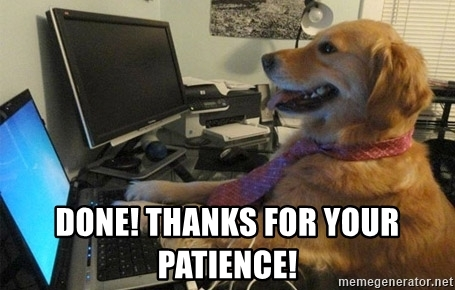